# Read the data

In [312]:
# Core Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from scipy.stats import kurtosis, skew
from scipy.stats.mstats import winsorize  # For outlier handling

# sklearn modules
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import BayesianRidge, LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, validation_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
import re
from warnings import simplefilter
simplefilter("ignore")


In [313]:
train = pd.read_csv('/kaggle/input/mytitanic/train.csv')
test = pd.read_csv('/kaggle/input/mytitanic/test.csv')


train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [314]:
print(f'The train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'The test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

The train dataset has 891 rows and 12 columns.
The test dataset has 418 rows and 11 columns.


In [315]:
print(f'The train dataset has {train.isna().sum().sum()} null values.')
print(f'The test dataset has {test.isna().sum().sum()} null values.')

The train dataset has 866 null values.
The test dataset has 414 null values.


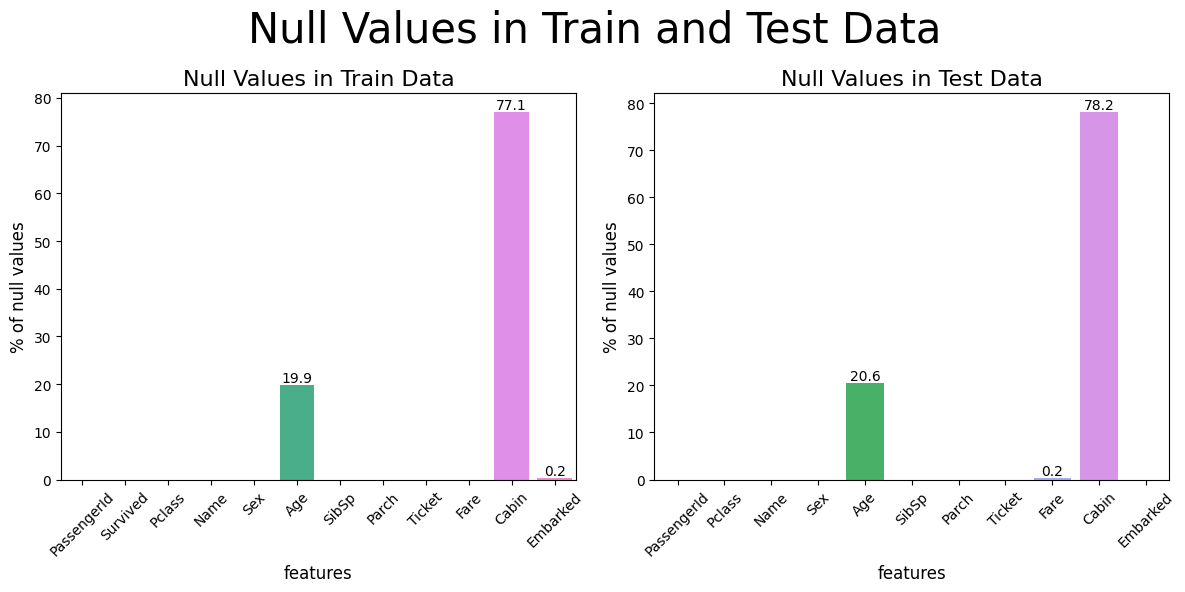

In [316]:
def plot_nulls(train, test):
    
    # number of nulls for each column
    data_nulls1 = (train.apply(lambda x: x.isnull().value_counts()).T[True]/len(train)*100).reset_index(name='count')
    data_nulls2 = (test.apply(lambda x: x.isnull().value_counts()).T[True]/len(test)*100).reset_index(name='count')

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

    ax1 = sns.barplot(data_nulls1, x="index", y="count", ax=ax1)
    ax1.set_title('Null Values in Train Data', fontsize=16)
    ax1.set_xlabel('features', fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_ylabel('% of null values', fontsize=12)
    ax1.bar_label(ax1.containers[0], fmt='%.1f')
    
    ax2 = sns.barplot(data_nulls2, x="index", y="count", ax=ax2)
    ax2.set_title('Null Values in Test Data', fontsize=16)
    ax2.set_xlabel('features', fontsize=12)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.set_ylabel('% of null values', fontsize=12)
    ax2.bar_label(ax2.containers[0], fmt='%.1f')

    plt.suptitle('Null Values in Train and Test Data', size=30)
    
    plt.tight_layout()
    plt.show()


plot_nulls(train, test)

In [317]:
print(f'The train dataset has {train.duplicated().sum()} duplicate rows.')

print(f'The test dataset has {test.duplicated().sum()} duplicate rows.')

The train dataset has 0 duplicate rows.
The test dataset has 0 duplicate rows.


In [318]:
train.dtypes


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [319]:
train.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [320]:
# Save the target variable of the train dataset
target = train["Survived"]

test_id = test["PassengerId"]

# Drop the 'PassengerId' index
train = train.drop(["PassengerId"], axis=1)
test  = test.drop(["PassengerId"], axis=1)

# Drop the 'Transported' variable from the train dataset
train2 = train.copy()
train = train.drop(["Survived"], axis=1)

train.head()


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [321]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Exploratory Data Analysis

## Total Survival Rate

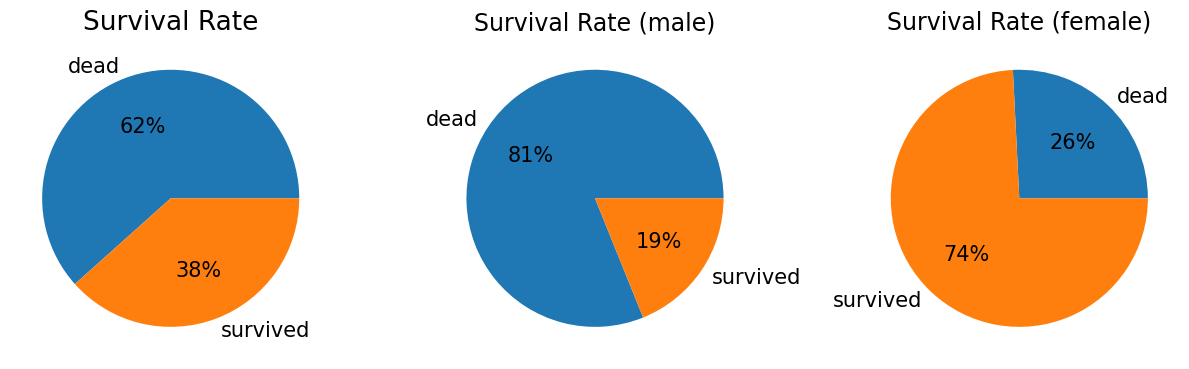

In [322]:
survival_rate = {0:'dead', 1:'survived'}

train2['survival_rate'] = train2['Survived'].map(survival_rate)

def label_function(val):
    return f'{val:.0f}%'

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

labels = ['survived','died']

train2.groupby('survival_rate').size().plot(kind='pie',autopct=label_function, textprops={'fontsize':15}, ax=ax1)
train2[train2['Sex'] == 'male'].groupby('survival_rate').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax2)
train2[train2['Sex'] == 'female'].groupby('survival_rate').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax3)

ax1.set_title('Survival Rate', size=19)
ax2.set_title('Survival Rate (male)', size=17)
ax3.set_title('Survival Rate (female)', size=17)
plt.tight_layout()
plt.show()


## Total Age Distribution

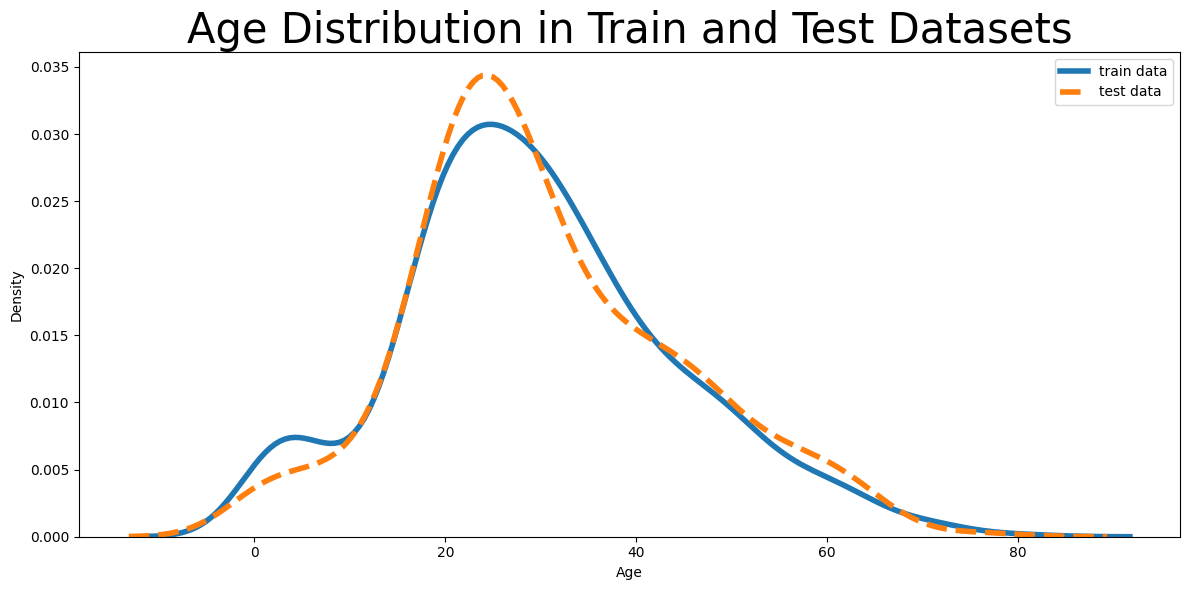

In [323]:
plt.figure(figsize=(12,6))

sns.kdeplot(train.Age, linewidth=4, label='train data') 
sns.kdeplot(test.Age, linewidth=4, linestyle='--', label='test data') 
plt.title('Age Distribution in Train and Test Datasets', size=30)
plt.legend()

plt.tight_layout()

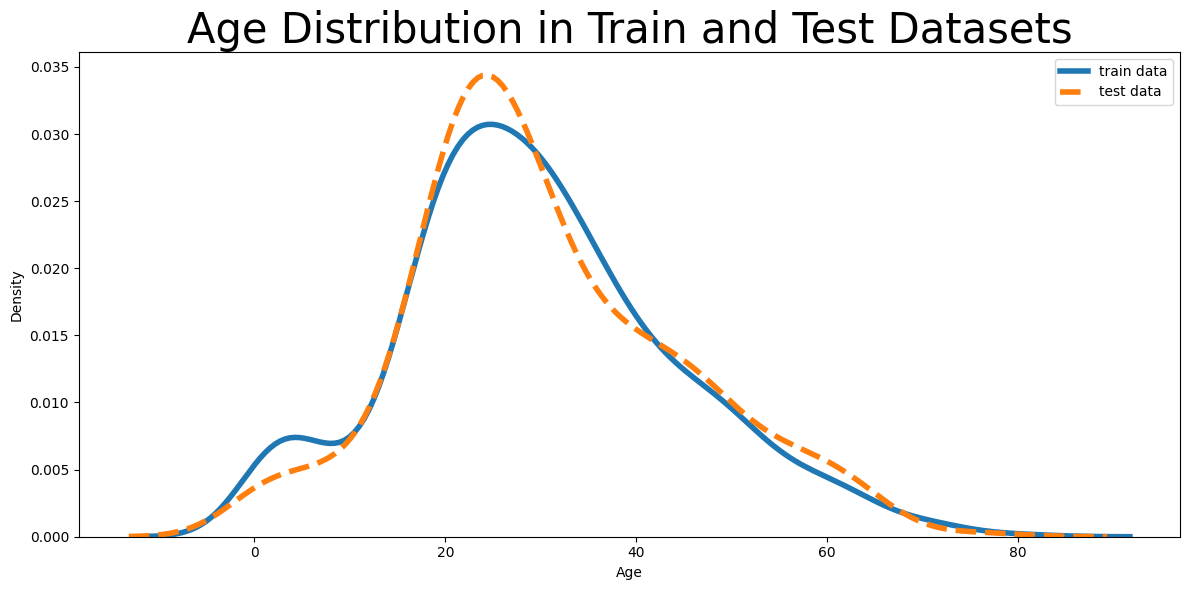

In [324]:
age_no_nulls_train = train.Age.dropna()
age_no_nulls_test = test.Age.dropna()

plt.figure(figsize=(12,6))

sns.kdeplot(age_no_nulls_train, linewidth=4, label='train data') 
sns.kdeplot(age_no_nulls_test, linewidth=4, linestyle='--', label='test data') 
plt.title('Age Distribution in Train and Test Datasets', size=30)
plt.legend()

plt.tight_layout()

In [325]:
age_no_nulls_train = train.Age.dropna()
age_no_nulls_test = test.Age.dropna()

print(f'Mean Value of Age: {train.Age.mean():.1f} (train), {test.Age.mean():.1f} (test)')

print(f"Skewness of Age: {skew(age_no_nulls_train):.2f} (train), {skew(age_no_nulls_test):.2f} (test)")

print(f"Kurtosis of Age: {kurtosis(age_no_nulls_train):.2f} (train), {kurtosis(age_no_nulls_test):.2f} (test)")

Mean Value of Age: 29.7 (train), 30.3 (test)
Skewness of Age: 0.39 (train), 0.46 (test)
Kurtosis of Age: 0.17 (train), 0.06 (test)


The test data has a higher skewness to the train data, implying a greater small positive (left) skew
The higher kurtosis just means the gradient from the peak to the tail is high. It is 0 at the normal distribution and negative for anything less steeper. The code doesn't make sense to output 0.17 for train and 0.06 for test based off of the distribution. So let's look at a box-plot.

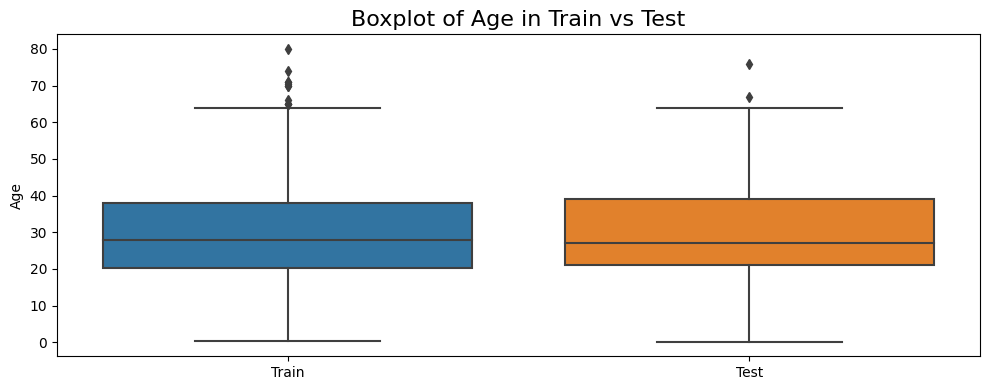

In [326]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=[age_no_nulls_train, age_no_nulls_test])
plt.xticks([0, 1], ['Train', 'Test'])
plt.title('Boxplot of Age in Train vs Test', fontsize=16)
plt.ylabel('Age')
plt.tight_layout()
plt.show()

The box-plot shows why the kurtosis is higher in the train as it has more outliers. This means there are more extreme values in the tails. Kurtosis measures the "tailedness" of a distribution — not just the outliers themselves, but how sharp and heavy the tails are. So it makes sense. Another insight from this boxplot is that the train has a slightly higher median than the test.

## Survival Rate by Age

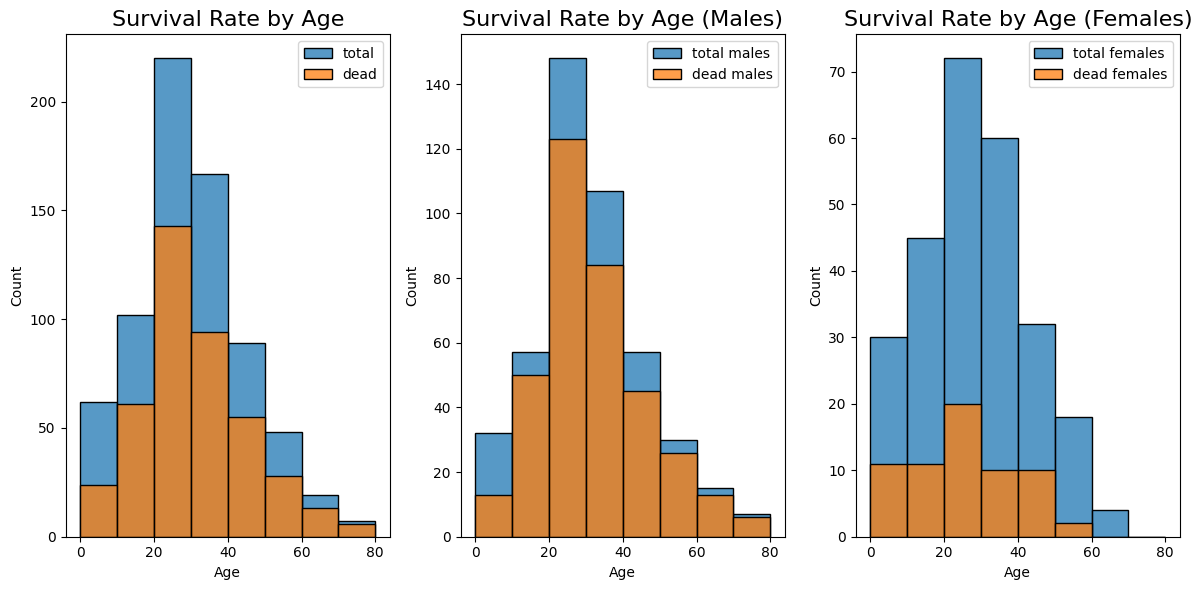

In [327]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,6))

ax1 = sns.histplot(train2.Age, bins=[0,10,20,30,40,50,60,70,80], label='total', ax=ax1)
ax1 = sns.histplot(train2[train2.Survived == 0]['Age'], bins=[0,10,20,30,40,50,60,70,80], label='dead', ax=ax1)
ax1.set_title('Survival Rate by Age', size=16)
ax1.legend()

ax2 = sns.histplot(train2[train2.Sex == 'male']['Age'], bins=[0,10,20,30,40,50,60,70,80], label='total males', ax=ax2)
ax2 = sns.histplot(train2[(train2.Sex == 'male') & (train2.Survived == 0)]['Age'], bins=[0,10,20,30,40,50,60,70,80], label='dead males', ax=ax2)
ax2.set_title('Survival Rate by Age (Males)', size=16)
ax2.legend()

ax3 = sns.histplot(train2[train2.Sex == 'female']['Age'], bins=[0,10,20,30,40,50,60,70,80], label='total females', ax=ax3)
ax3 = sns.histplot(train2[(train2.Sex == 'female') & (train2.Survived == 0)]['Age'], bins=[0,10,20,30,40,50,60,70,80], label='dead females', ax=ax3)
ax3.set_title('Survival Rate by Age (Females)', size=16)
ax3.legend()

plt.tight_layout()

Women had a much higher survival rate as seen by the final histogram

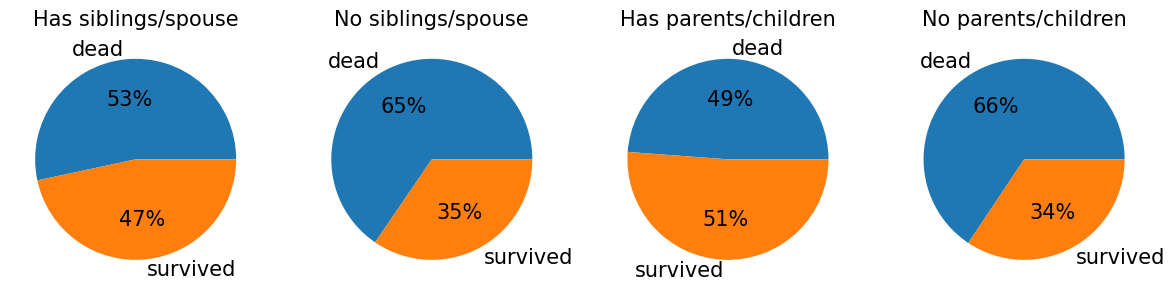

In [328]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,6))

labels = ['survived','died']

train2[train2['SibSp'] >= 1].groupby('survival_rate').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax1)
train2[train2['SibSp'] == 0].groupby('survival_rate').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax2)
train2[train2['Parch'] >= 1].groupby('survival_rate').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax3)
train2[train2['Parch'] == 0].groupby('survival_rate').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax4)

ax1.set_title('Has siblings/spouse',size=15)
ax2.set_title('No siblings/spouse',size=15)
ax3.set_title('Has parents/children',size=15)
ax4.set_title('No parents/children',size=15)

plt.tight_layout()
plt.show()

Passengers with family had a higher survival rate

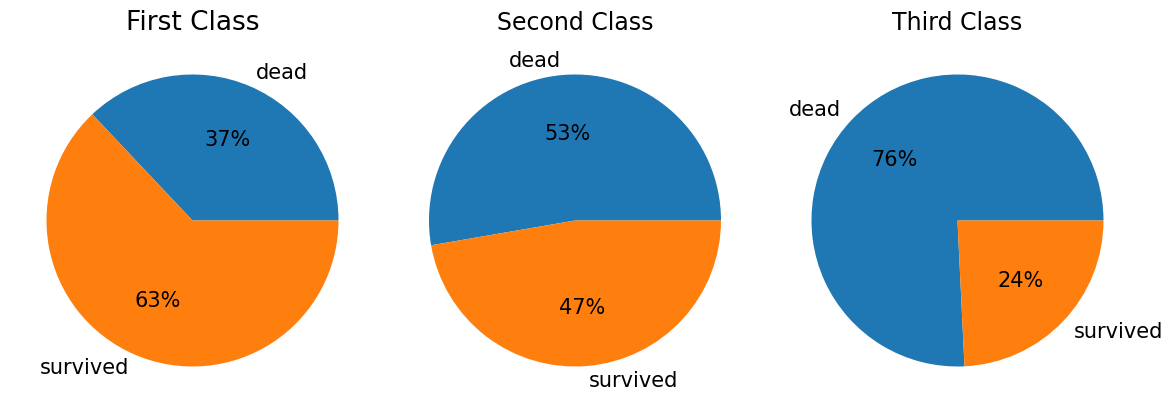

In [329]:
train2['survival_rate'] = train2['Survived'].map(survival_rate)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

labels = ['survived','died']

train2[train2['Pclass'] == 1].groupby('survival_rate').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax1)
train2[train2['Pclass'] == 2].groupby('survival_rate').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax2)
train2[train2['Pclass'] == 3].groupby('survival_rate').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax3)

ax1.set_title('First Class',size=19)
ax2.set_title('Second Class',size=17)
ax3.set_title('Third Class',size=17)

plt.tight_layout()
plt.show()

The majority of people from the first class survived, about half of those of the second class survived and around a quarter of those of the third class.

<Figure size 1200x600 with 0 Axes>

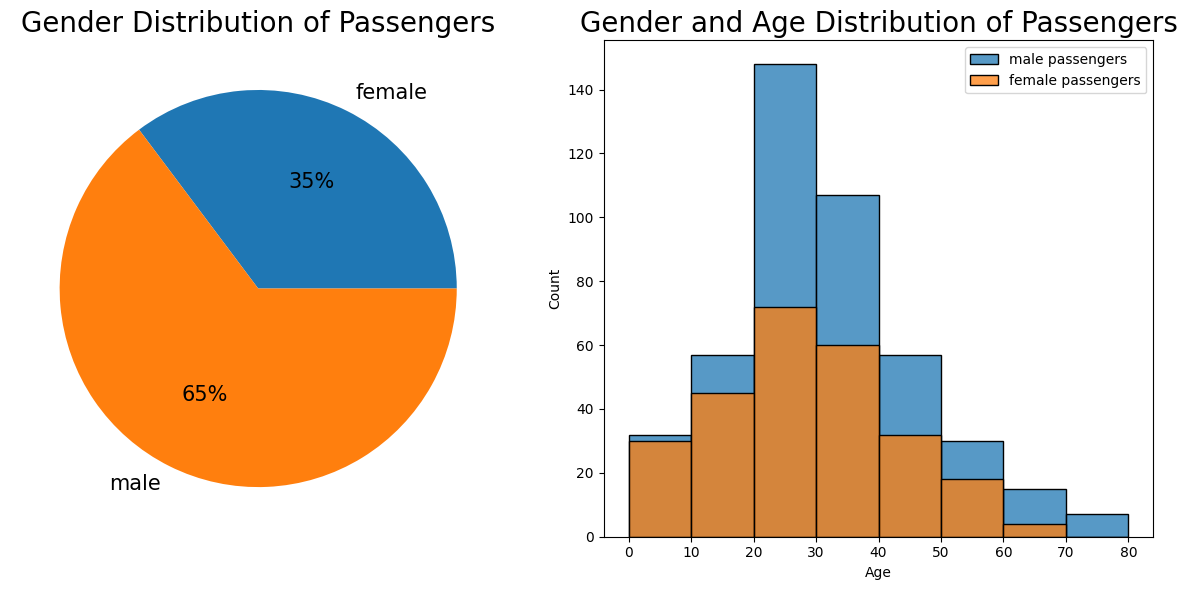

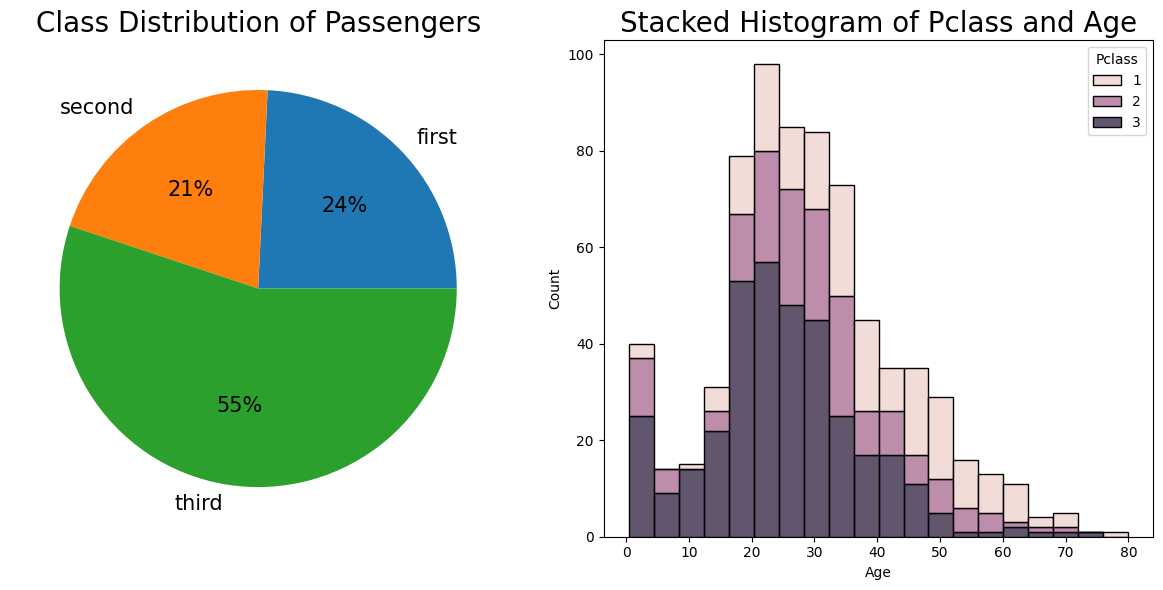

In [330]:
bigfig = plt.figure(figsize=(12,6))

(top,bottom) = bigfig.subfigures(2,1)

### Top figures ###
top.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

train.groupby('Sex').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax1)
ax1.set_title('Gender Distribution of Passengers', size=20)

ax2 = sns.histplot(train[train.Sex == 'male'].Age, bins=[0,10,20,30,40,50,60,70,80], label='male passengers')
ax2 = sns.histplot(train[train.Sex == 'female'].Age, bins=[0,10,20,30,40,50,60,70,80], label='female passengers')
ax2.legend()
ax2.set_title('Gender and Age Distribution of Passengers', size=20)

plt.tight_layout()

### Bottom figures ###
bottom.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

train.groupby('Pclass').size().plot(kind='pie', autopct=label_function, textprops={'fontsize':15}, ax=ax1, labels=['first','second','third'])
ax1.set_title('Class Distribution of Passengers', size=20)

ax2 = sns.histplot(data=train, x='Age', multiple='stack', hue='Pclass', ax=ax2)
ax2.set_title('Stacked Histogram of Pclass and Age', size=20)

plt.tight_layout()

# Creating New Features

## Honorifics

Create an 'honorifics' column to see if the final survival rate prediction can be improved

In [331]:
def get_title(name):
    
    # Titles always consist of capital and lowercase letters and end with a period.
    # Takes a name as input and returns the title string as output.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


train["Honorific"] = train["Name"].apply(get_title)
test["Honorific"]  = test["Name"].apply(get_title)

train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorific
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


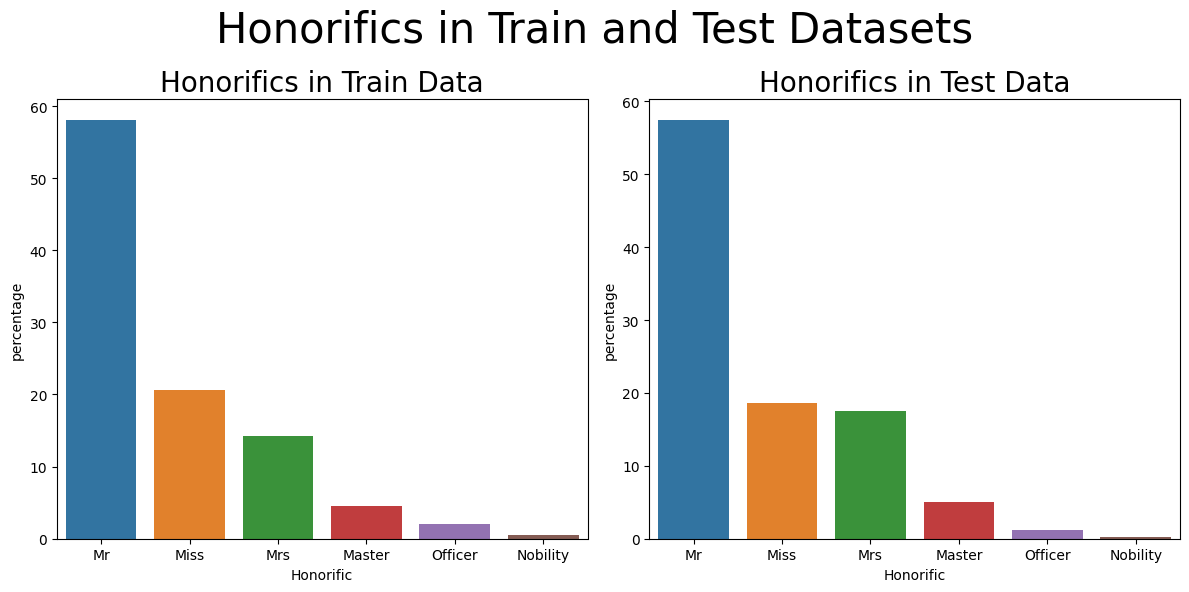

In [332]:
# Create a simpler classification
honDictionary = {"Capt":"Officer","Col":"Officer","Major":"Officer","Jonkheer":"Nobility","Don":"Nobility",
                 "Sir":"Nobility","Dr":"Officer","Rev":"Officer","Countess":"Nobility","Dona":"Nobility",
                 "Mme":"Mrs","Mlle":"Miss","Ms":"Mrs","Mr":"Mr","Mrs":"Mrs","Miss":"Miss","Master":"Master",
                 "Lady":"Nobility"}

def titlemap(x):
    return honDictionary[x]

train["Honorific"] = train["Honorific"].apply(titlemap)
test["Honorific"] = test["Honorific"].apply(titlemap)

train_honorifics = train.groupby('Honorific')['Honorific'].count().div(len(train)).mul(100).reset_index(name='percentage').sort_values(['percentage'],ascending= False)
test_honorifics  = test.groupby('Honorific')['Honorific'].count().div(len(test)).mul(100).reset_index(name='percentage').sort_values(['percentage'],ascending= False)


fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.barplot(data=train_honorifics, x="Honorific", y='percentage', ax=ax1)
ax1.set_title('Honorifics in Train Data', size=20)

ax2 = sns.barplot(data=test_honorifics, x="Honorific", y='percentage', ax=ax2)
ax2.set_title('Honorifics in Test Data', size=20)

plt.suptitle('Honorifics in Train and Test Datasets', size=30)

plt.tight_layout()

## Cabins + Decks

A cabin number looks like ‘C123’ and the letter refers to the deck. I create a new feature, that contains a person's deck. The Titanic deck feature can be important to estimate the people's survival rate.

In [333]:
train['Deck'] = train[~train['Cabin'].isna()]['Cabin'].apply(lambda x: str(x)[0])
test['Deck']  = test[~test['Cabin'].isna()]['Cabin'].apply(lambda x: str(x)[0])

train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

train.Deck.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

## Family Size

The family size is the sum of SibSp (number of siblings/spouses aboard the Titanic) and Parch (number of parents/children).



In [334]:
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize']  = test['SibSp'] + test['Parch']

## Single Mothers

Women and children had a higher survival rate than men.

Among women, married women with children often stayed with their families and might have faced more difficulties getting to lifeboats, especially if their husbands were involved in helping others or staying behind.

Single women with children may have had a slightly better chance if they were more mobile or separated from a husband, but many survival decisions depended heavily on where they were on the ship and how quickly they acted.

While single women might have had some advantage in terms of decision-making freedom compared to married women with children (who might have had to coordinate with their husbands), having multiple children would likely decrease the chance of survival because of the practical difficulties involved.

The first new column identifies mothers, who may have a higher chance of surviving with their children.

In [335]:
train['Mother'] = ((train['Honorific'] == 'Mrs') & (train['Parch'] > 0)).astype(int)

test['Mother'] = ((test['Honorific'] == 'Mrs') & (test['Parch'] > 0)).astype(int)

I will also consider a new feature that identifies singles.



In [336]:
train['Single'] = (train['SibSp'] + train['Parch'] + 1 == 1).astype(int)

test['Single'] = (test['SibSp'] + test['Parch'] + 1 == 1).astype(int)

## Drop unnecessary columns

In [337]:
train.drop(['Name','Ticket'], axis=1, inplace=True)

test.drop(['Name','Ticket'], axis=1, inplace=True)

train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Honorific,Deck,FamilySize,Mother,Single
0,3,male,22.0,1,0,7.2500,S,Mr,NaN,1,0,0
1,1,female,38.0,1,0,71.2833,C,Mrs,C,1,0,0
2,3,female,26.0,0,0,7.9250,S,Miss,NaN,0,0,1
3,1,female,35.0,1,0,53.1000,S,Mrs,C,1,0,0
4,3,male,35.0,0,0,8.0500,S,Mr,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S,Officer,NaN,0,0,1
887,1,female,19.0,0,0,30.0000,S,Miss,B,0,0,1
888,3,female,NaN,1,2,23.4500,S,Miss,NaN,3,0,0
889,1,male,26.0,0,0,30.0000,C,Mr,C,0,0,1


# Handling Missing Values

## Identifying Columns

In [338]:
# Categorical columns with nulls
cat_na_cols_train = [col for col in train.columns if train[col].dtypes == 'O' and train[col].isna().any()]
cat_na_cols_test  = [col for col in test.columns if test[col].dtypes == 'O' and test[col].isna().any()]

cat_na_cols_train, cat_na_cols_test

(['Embarked', 'Deck'], ['Deck'])

In [339]:
# Numerical columns with nulls
num_na_cols_train = [col for col in train.columns if train[col].dtypes != 'O' and train[col].isna().any()]
num_na_cols_test  = [col for col in test.columns if test[col].dtypes != 'O' and test[col].isna().any()]

num_na_cols_train, num_na_cols_test

(['Age'], ['Age', 'Fare'])

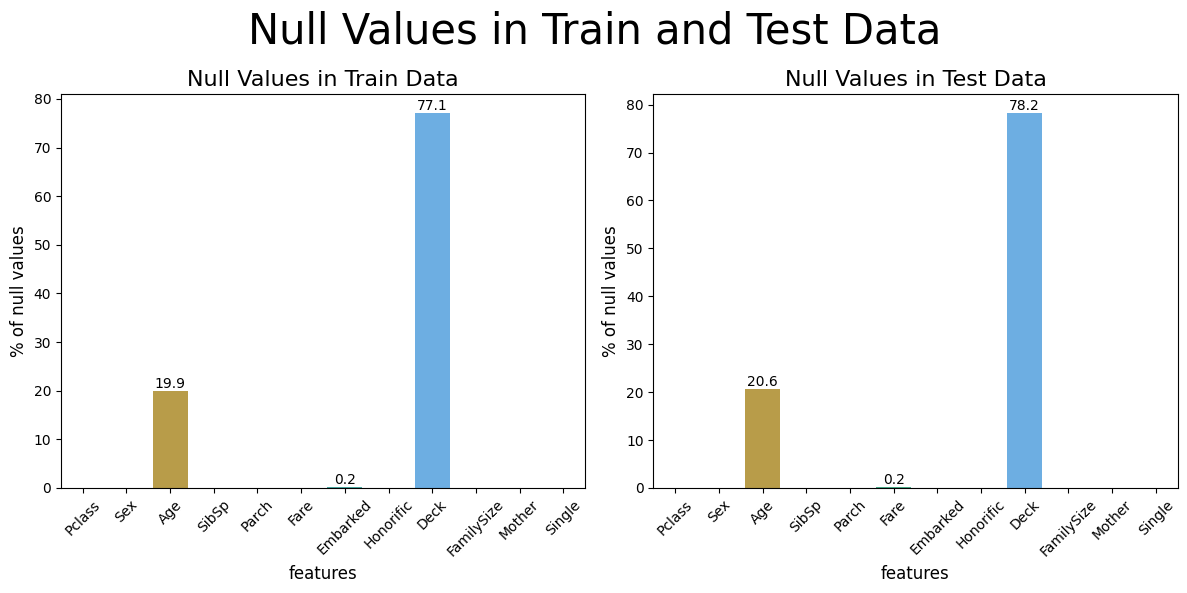

In [340]:
plot_nulls(train, test)

## Imputing the Nulls with Mean/Median and Mode

This is the first imputation strategy I consider. Here, I am imputing the null values of numerical variables with their median and the nulls of categorical variables with their mode.

In [341]:
train_i1 = train.copy()
test_i1 = test.copy()

# Define the ColumnTransformer with SimpleImputer
imputer = ColumnTransformer(
    transformers=[
        ("median_imputer", SimpleImputer(strategy="median"), num_na_cols_test),
        ("mode_imputer", SimpleImputer(strategy="most_frequent"), cat_na_cols_train)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

imputer.set_output(transform="pandas")

# Fit on training data
imputer.fit(train_i1)

# Transform both train and test
train_i1 = imputer.transform(train_i1)
test_i1 = imputer.transform(test_i1)

train_i1.head()


,Age,Fare,Embarked,Deck,Pclass,Sex,SibSp,Parch,Honorific,FamilySize,Mother,Single
0,22.0,7.2500,S,C,3,male,1,0,Mr,1,0,0
1,38.0,71.2833,C,C,1,female,1,0,Mrs,1,0,0
2,26.0,7.9250,S,C,3,female,0,0,Miss,0,0,1
3,35.0,53.1000,S,C,1,female,1,0,Mrs,1,0,0
4,35.0,8.0500,S,C,3,male,0,0,Mr,0,0,1


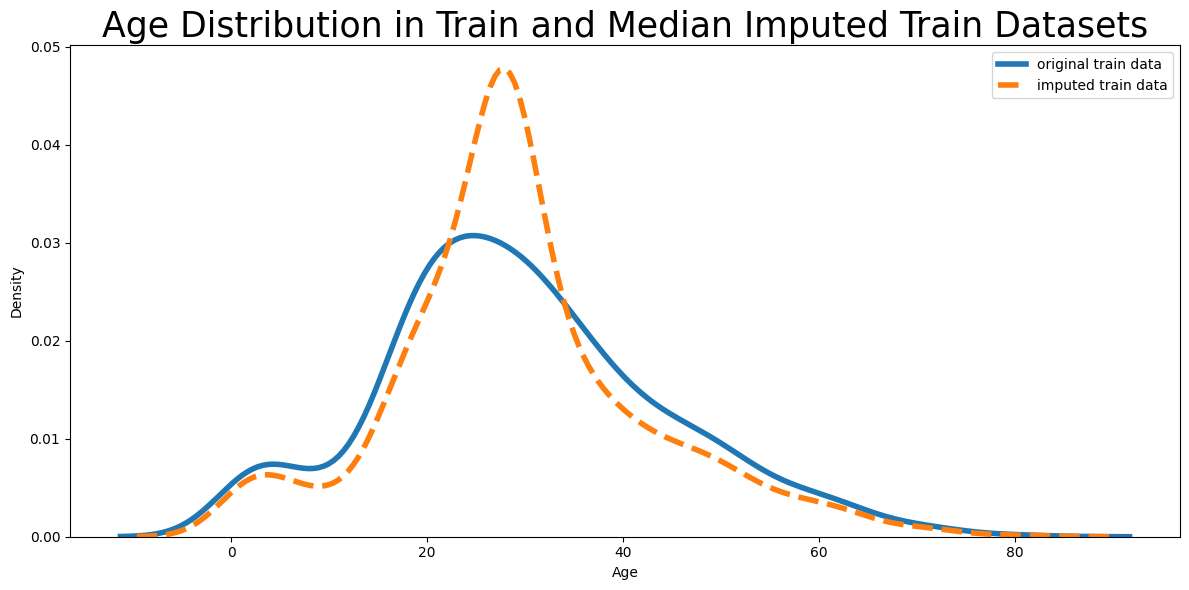

In [342]:
plt.figure(figsize=(12,6))

sns.kdeplot(train.Age, linewidth=4, label='original train data') 
sns.kdeplot(train_i1.Age, linewidth=4, linestyle='--', label='imputed train data') 
plt.title('Age Distribution in Train and Median Imputed Train Datasets', size=25)
plt.legend()

plt.tight_layout()

The plot shows a comparison of the original Age distribution and the corresponding distribution obtained by median imputation. As expected, the imputed distribution is characterized by a higher peak around the median value of age.

In [343]:
age_dist = train.dropna()['Age']

print(f"Skewness of Age (original): {skew(age_dist)}")
print(f"Kurtosis of Age (original): {kurtosis(age_dist)}")

print(f"Skewness of Age (imputed): {skew(train_i1.Age)}")
print(f"Kurtosis of Age (imputed): {kurtosis(train_i1.Age)}")

Skewness of Age (original): 0.009596348004222129
Kurtosis of Age (original): -0.2526594531274511
Skewness of Age (imputed): 0.5093852558219664
Kurtosis of Age (imputed): 0.9815760369363535


The imputation process determined a change in the values of the skewness and kurtosis of the Age distribution.

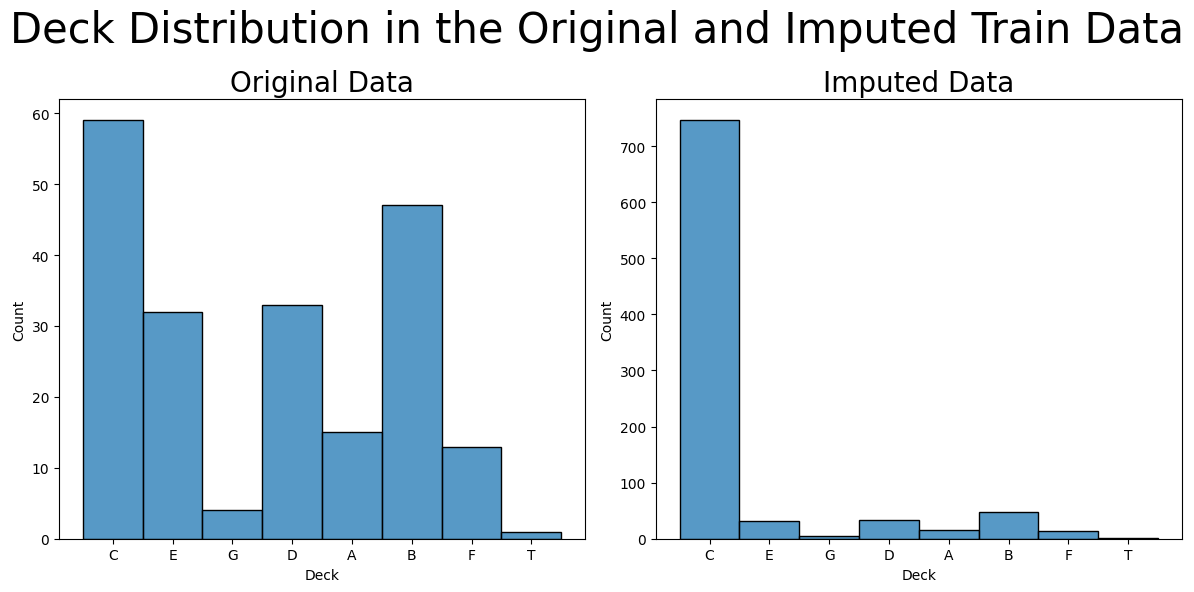

In [344]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.histplot(train['Deck'], ax=ax1)
ax1.set_title('Original Data', size=20)

ax2 = sns.histplot(train_i1['Deck'], ax=ax2)
ax2.set_title('Imputed Data', size=20)

plt.suptitle('Deck Distribution in the Original and Imputed Train Data', size=30)

plt.tight_layout()

One can notice that the two distributions are completely different. This is because:

The fraction of missing values in the Deck variable was close to 80%.
The imputation strategy by mode gave all the missing values to the majority class, i.e. C.

## Mean/Median Imputation per Group

I am creating an imputation dictionary for the numerical variables with null values: Age and Fare. The dictionary will include the median values of those variables, calculated over the male and female classes

In [345]:
train_i2 = train.copy()
test_i2  = test.copy()

imputation_dict_num = {}

for i in train_i2["Sex"].unique():
    imputation_dict_num[i] = (
        train_i2[train_i2["Sex"] == i][num_na_cols_test].median().to_dict()
    )

imputation_dict_num

{'male': {'Age': 29.0, 'Fare': 10.5}, 'female': {'Age': 27.0, 'Fare': 23.0}}

Now, I will replace the missing values in those columns by means of the dictionary.



In [346]:
# Replace missing data
for i in imputation_dict_num.keys():
    
    train_i2[train_i2["Sex"] == i] = train_i2[train_i2["Sex"] == i].fillna(
        imputation_dict_num[i]
    )
    
    test_i2[test_i2["Sex"] == i] = test_i2[test_i2["Sex"] == i].fillna(
        imputation_dict_num[i]
    )


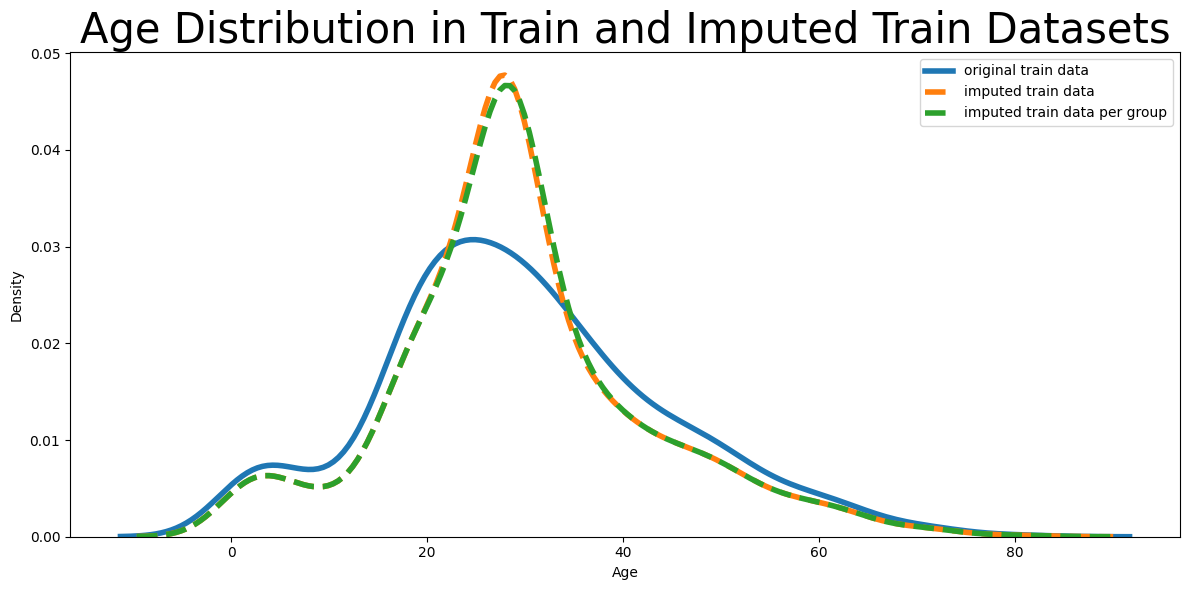

In [347]:
plt.figure(figsize=(12,6))

sns.kdeplot(train.Age, linewidth=4, label='original train data') 
sns.kdeplot(train_i1.Age, linewidth=4, linestyle='--', label='imputed train data') 
sns.kdeplot(train_i2.Age, linewidth=4, linestyle='--', label='imputed train data per group') 
plt.title('Age Distribution in Train and Imputed Train Datasets', size=30)
plt.legend()

plt.tight_layout()

It seems that the Age distributions obtained by imputing with the median or the median per gender are very similar.

**train_i1.Age :** 
Look at all non-missing Age values in the whole training set.
Compute the median Age, say 27.
Fill in all missing Age values, regardless of whether the person is male or female, with 27.
E.g. Alice (female) → Age = NaN → filled with 27

**train_i2.Age:**
First split the data by Sex (e.g., "male" and "female").
For each group, calculate that group's median Age:
Male median: 29
Female median: 24
Fill in missing values using the median of their group.
E.g 
Alice (female) → Age = NaN → filled with 24
Bob (male) → Age = NaN → filled with 29

## Random Imputation

I am imputing the null values by random sampling from the distributions in the train dataset

In [348]:
# --- Base imputer (unchanged for Age etc.) ---
class RandomSampleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=None):
        self.random_state = random_state
    
    def fit(self, X, y=None):
        self.sample_values_ = X.dropna(axis=1, how='all').apply(lambda col: col.dropna().values, axis=0)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            if col != 'Deck' and X[col].isnull().any():
                available_values = self.sample_values_[col]
                np.random.seed(self.random_state)
                X_transformed[col] = X[col].apply(
                    lambda x: np.random.choice(available_values) if pd.isnull(x) else x
                )
        return X_transformed

# --- Uniform random imputation for Deck ---
def uniform_random_impute(series, random_state=None):
    np.random.seed(random_state)
    available_values = series.dropna().values
    missing_idx = series[series.isna()].index
    imputed_values = np.random.choice(available_values, size=len(missing_idx))
    series_imputed = series.copy()
    series_imputed.loc[missing_idx] = imputed_values
    return series_imputed

# --- Apply imputations ---
train_i3 = train.copy()
test_i3  = test.copy()

# Impute numeric (like Age) and other non-Deck columns
imputer = RandomSampleImputer(random_state=42)
imputer.fit(train_i3)

train_i3 = imputer.transform(train_i3)
test_i3  = imputer.transform(test_i3)

# Impute Deck using uniform random sampling
train_i3['Deck'] = uniform_random_impute(train['Deck'], random_state=42)
test_i3['Deck']  = uniform_random_impute(test['Deck'], random_state=42)

Below, I am comparing the distributions of Age and Deck in the 'original' and random imputed train datasets.



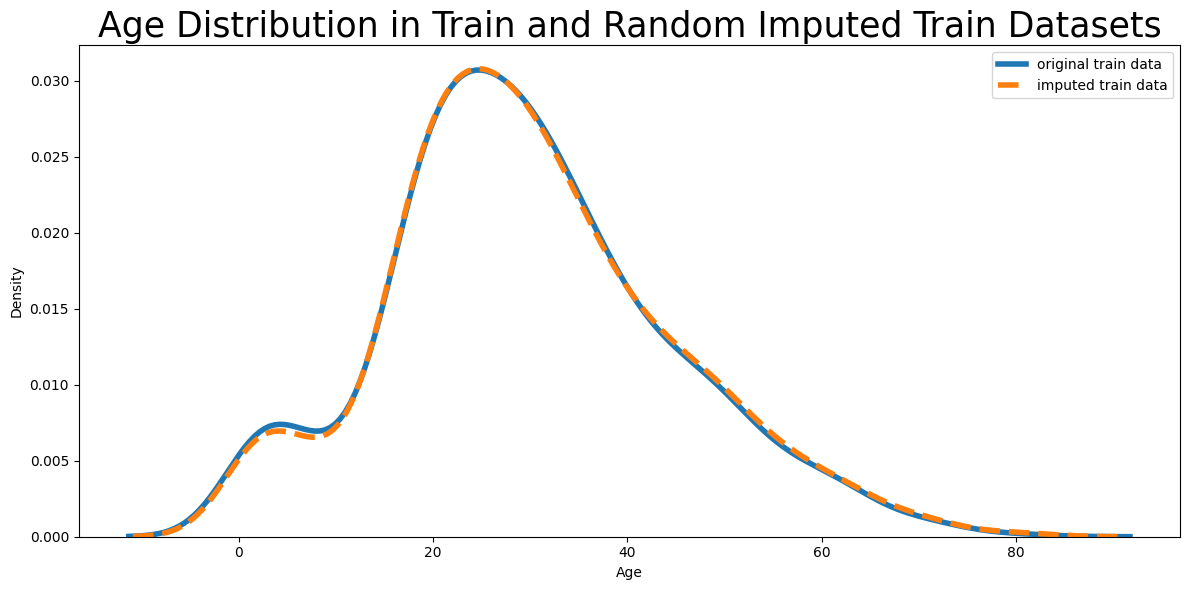

In [349]:
plt.figure(figsize=(12,6))

sns.kdeplot(train.Age, linewidth=4, label='original train data') 
sns.kdeplot(train_i3.Age, linewidth=4, linestyle='--', label='imputed train data') 
plt.title('Age Distribution in Train and Random Imputed Train Datasets', size=25)
plt.legend()

plt.tight_layout()

The Age distributions are very similar. They almost coincide.



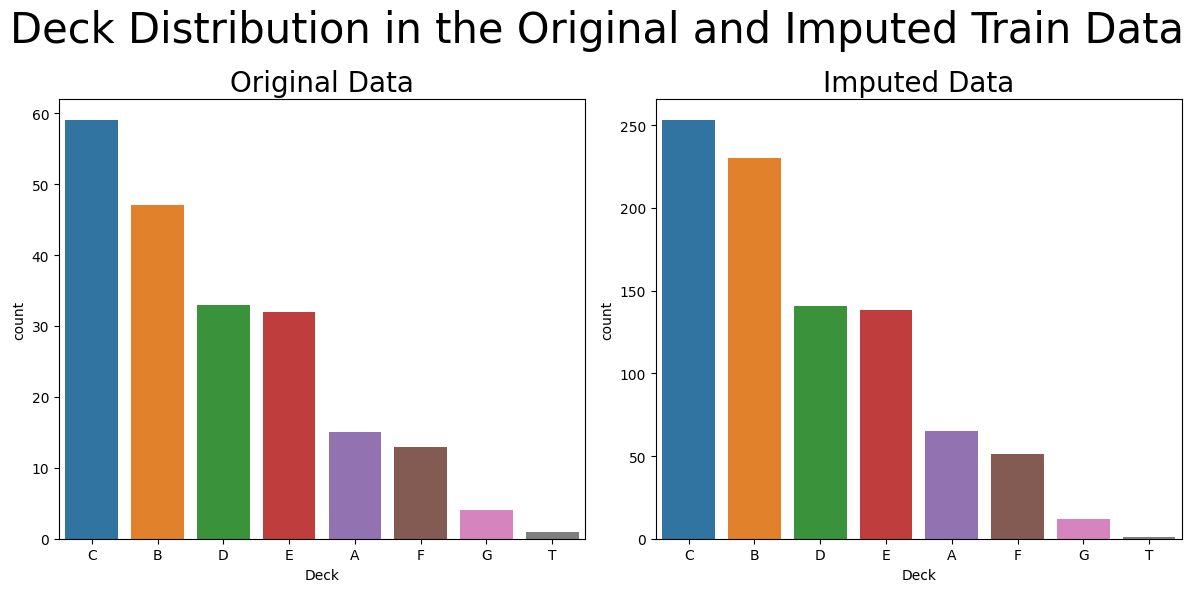

In [350]:
orig_deck_dist  = train['Deck'].value_counts().reset_index().sort_values(by='count', ascending=False)

imput_deck_dist = train_i3['Deck'].value_counts().reset_index().sort_values(by='count', ascending=False)


fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.barplot(data=orig_deck_dist, x='Deck', y='count', ax=ax1)
ax1.set_title('Original Data', size=20)

ax2 = sns.barplot(data=imput_deck_dist, x='Deck', y='count', ax=ax2)
ax2.set_title('Imputed Data', size=20)

plt.suptitle('Deck Distribution in the Original and Imputed Train Data', size=30)

plt.tight_layout()

Also the Deck distributions are quite similar.

However, one should keep in mind that random imputation may **affect the relationships between the variables**.

## Stratified Random Sampling Imputation

I tried stratified random sampling to see if i get a better prediction than just uniform random sampling

In [351]:
class StratifiedRandomSampleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, stratify_col=None, random_state=None):
        self.stratify_col = stratify_col
        self.random_state = random_state
        self.sample_values_ = {}

    def fit(self, X, y=None):
        X_ = X.copy()
        if self.stratify_col and self.stratify_col in X_.columns:
            for col in X_.columns:
                self.sample_values_[col] = {}
                for group in X_[self.stratify_col].dropna().unique():
                    non_missing = X_[(X_[self.stratify_col] == group)][col].dropna().values
                    if len(non_missing) > 0:
                        self.sample_values_[col][group] = non_missing
        else:
            self.sample_values_ = X_.dropna(axis=1, how='all').apply(lambda col: col.dropna().values, axis=0).to_dict()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        np.random.seed(self.random_state)

        for col in X.columns:
            if X[col].isnull().any():
                if self.stratify_col and self.stratify_col in X.columns:
                    for group in X[self.stratify_col].dropna().unique():
                        mask = (X[col].isnull()) & (X[self.stratify_col] == group)
                        if group in self.sample_values_.get(col, {}):
                            values = self.sample_values_[col][group]
                            X_transformed.loc[mask, col] = np.random.choice(values, size=mask.sum(), replace=True)
                else:
                    values = self.sample_values_.get(col, [])
                    if len(values) > 0:
                        mask = X[col].isnull()
                        X_transformed.loc[mask, col] = np.random.choice(values, size=mask.sum(), replace=True)
        return X_transformed

# Make copies
train_i31 = train.copy()
test_i31  = test.copy()

# Initialize stratified imputer on 'Pclass'
imputer = StratifiedRandomSampleImputer(stratify_col='Pclass', random_state=42)

# Fit on train data
imputer.fit(train_i31)

# Transform both datasets
train_i31 = imputer.transform(train_i31)
test_i31  = imputer.transform(test_i31)

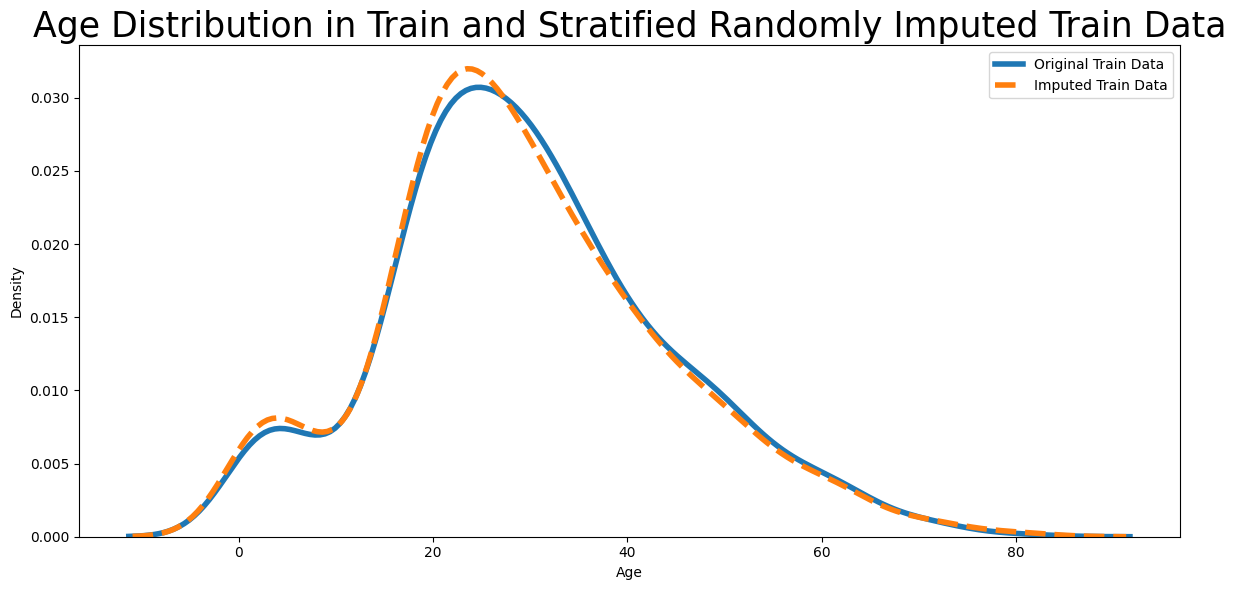

In [352]:
plt.figure(figsize=(12,6))

sns.kdeplot(train['Age'].dropna(), linewidth=4, label='Original Train Data') 
sns.kdeplot(train_i31['Age'], linewidth=4, linestyle='--', label='Imputed Train Data') 

plt.title('Age Distribution in Train and Stratified Randomly Imputed Train Data', size=25)
plt.legend()
plt.tight_layout()

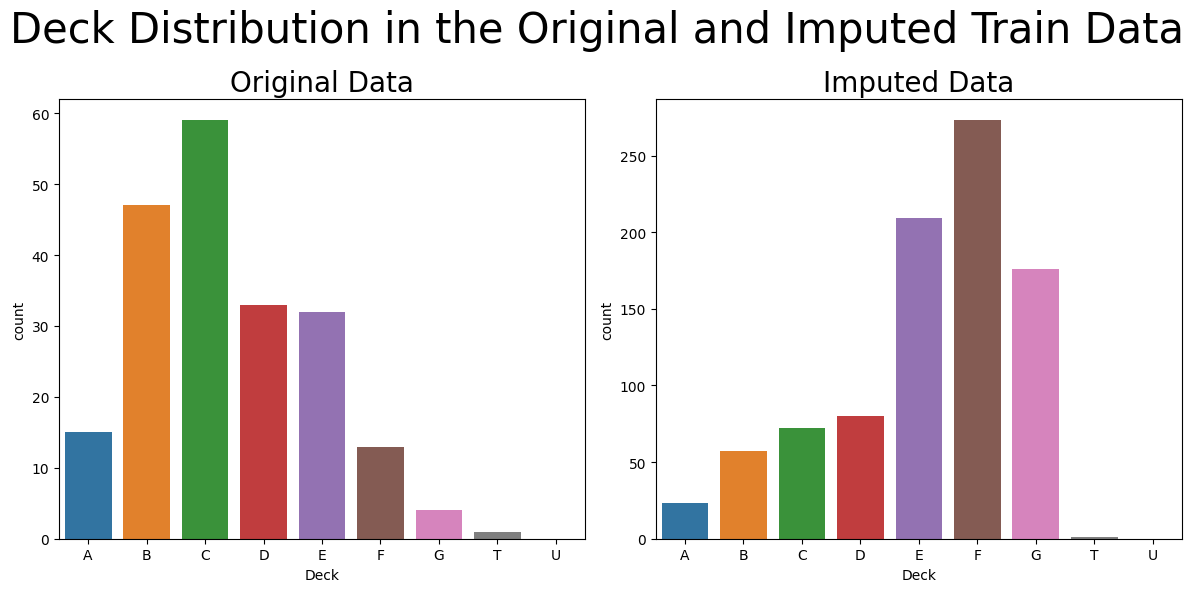

In [353]:
# Define a consistent Deck order
deck_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U']  # Add or remove based on your dataset

# Get deck distributions
orig_deck_dist = train['Deck'].value_counts().reindex(deck_order).fillna(0).reset_index()
orig_deck_dist.columns = ['Deck', 'count']

imput_deck_dist = train_i31['Deck'].value_counts().reindex(deck_order).fillna(0).reset_index()
imput_deck_dist.columns = ['Deck', 'count']

# Convert Deck to categorical with order for plotting
orig_deck_dist['Deck'] = pd.Categorical(orig_deck_dist['Deck'], categories=deck_order, ordered=True)
imput_deck_dist['Deck'] = pd.Categorical(imput_deck_dist['Deck'], categories=deck_order, ordered=True)

# Sort to ensure correct order
orig_deck_dist = orig_deck_dist.sort_values('Deck')
imput_deck_dist = imput_deck_dist.sort_values('Deck')

# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

sns.barplot(data=orig_deck_dist, x='Deck', y='count', ax=ax1, order=deck_order)
ax1.set_title('Original Data', size=20)

sns.barplot(data=imput_deck_dist, x='Deck', y='count', ax=ax2, order=deck_order)
ax2.set_title('Imputed Data', size=20)

plt.suptitle('Deck Distribution in the Original and Imputed Train Data', size=30)
plt.tight_layout()



Stratified random imputation can perform worse than standard random imputation when the groups being stratified on (like Pclass or Sex) have small sample sizes or weak relationships with the missing variable. This limits the diversity of possible values for imputation and can introduce bias or overfitting. Additionally, if the stratified distributions differ significantly between training and test sets, it can lead to inconsistencies and hurt model performance. However, unstratified random imputation draws from the full available distribution, which may better preserve the overall variance and generalisation.

## Imputation with Mice

MICE, short for Multivariate Imputation by Chained Equations, is a missing data imputation technique that uses multiple imputations. MICE aims to impute, or 'fill in', missing values by using information from other variables in the dataset.

I will use Mice first to impute the nulls in the numerical variables.

In [354]:
# num_cols = ["Pclass","Age","SibSp","Parch","Fare","FamilySize"]
num_cols = [col for col in train.columns if train[col].dtypes != 'O']

# Use numeric features only
df_train = train.loc[:, num_cols]
df_test  = test.loc[:, num_cols]

df_train.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Mother,Single
0,3,22.0,1,0,7.2500,1,0,0
1,1,38.0,1,0,71.2833,1,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,1,0,0
4,3,35.0,0,0,8.0500,0,0,1


I want to compare the imputation results from different models. So the way an iterative imputer works is, say you have 3 features A,B,C. If A and B have null values you mean/median impute B. And then you predict the null values in A. Then with these new predicted A values you can predict B's null values. This is all per row. And then you keep doing this for multiple iterations. The way you predict these values for A and then B are by using these estimators below. This is basically what MICE is (using multiple features in the same row to predict each others' values).



In [355]:
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=100,
    random_state=0)

imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=5),
    max_iter=100,
    random_state=0)

imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0),
    max_iter=500,
    random_state=0)

imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
    max_iter=100,
    random_state=0)

imputer_bayes.fit(df_train)
imputer_knn.fit(df_train)
imputer_nonLin.fit(df_train)
imputer_missForest.fit(df_train)

IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
                 max_iter=100, random_state=0)

In [356]:
X_train_bayes = imputer_bayes.transform(df_train)
X_train_knn = imputer_knn.transform(df_train)
X_train_nonLin = imputer_nonLin.transform(df_train)
X_train_missForest = imputer_missForest.transform(df_train)

X_test_bayes = imputer_bayes.transform(df_test)
X_test_knn = imputer_knn.transform(df_test)
X_test_nonLin = imputer_nonLin.transform(df_test)
X_test_missForest = imputer_missForest.transform(df_test)

# Transform numpy array to dataframe
X_train_bayes = pd.DataFrame(X_train_bayes, columns=num_cols)
X_train_knn = pd.DataFrame(X_train_knn, columns=num_cols)
X_train_nonLin = pd.DataFrame(X_train_nonLin, columns=num_cols)
X_train_missForest = pd.DataFrame(X_train_missForest, columns=num_cols)

X_test_bayes = pd.DataFrame(X_test_bayes, columns=num_cols)
X_test_knn = pd.DataFrame(X_test_knn, columns=num_cols)
X_test_nonLin = pd.DataFrame(X_test_nonLin, columns=num_cols)
X_test_missForest = pd.DataFrame(X_test_missForest, columns=num_cols)

Here, I am comparing the 'original' Age distribution to the distributions obtained with the different imputation models.



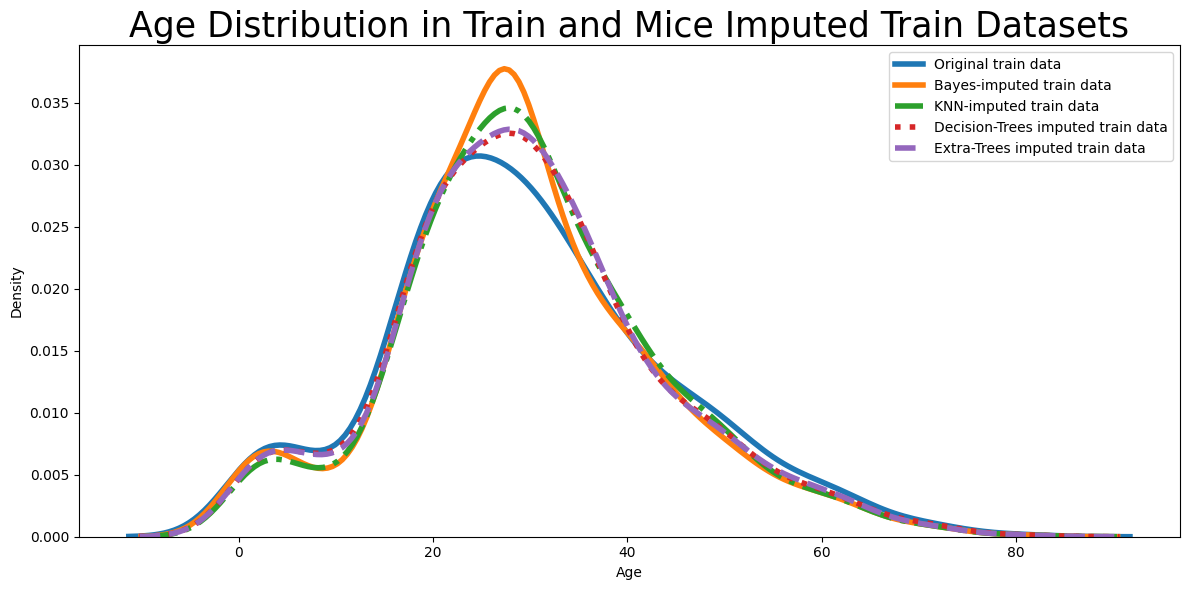

In [357]:
plt.figure(figsize=(12,6))

sns.kdeplot(train.Age, linewidth=4, label='Original train data') 
sns.kdeplot(X_train_bayes.Age, linewidth=4, label='Bayes-imputed train data') 
sns.kdeplot(X_train_knn.Age, linewidth=4, linestyle='-.', label='KNN-imputed train data') 
sns.kdeplot(X_train_nonLin.Age, linewidth=4, linestyle=':', label='Decision-Trees imputed train data') 
sns.kdeplot(X_train_missForest.Age, linewidth=4, linestyle='--', label='Extra-Trees imputed train data') 
plt.title('Age Distribution in Train and Mice Imputed Train Datasets', size=25)
plt.legend()

plt.tight_layout()

## Imputation with MissForest

MissForest algorithm is a powerful tool designed to handle missing values in tabular datasets.
MissForest is a specific case of the general MICE framework, where:

- The imputation model is Random Forest

- Categorical + numeric support is built-in

- It’s usually more robust for complex, nonlinear, real-world data




In [358]:
# cat_cols = ['Sex','Embarked','Honorific','Deck']
cat_cols = [col for col in train.columns if train[col].dtypes == 'O']

train_i5 = train.copy()
test_i5  = test.copy()

encoder = LabelEncoder()

for col in cat_cols:
    train_i5[col] = encoder.fit_transform(train_i5[col])
    test_i5[col]  = encoder.transform(test_i5[col])

In [359]:
imputer = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=100, random_state=0),  # For numerical columns
    max_iter=20,
    random_state=0
)

# Fit and transform the training set
train_i5 = imputer.fit_transform(train_i5)

# Transform the test set
test_i5 = imputer.transform(test_i5)

# Convert the result back into a DataFrame
train_i5 = pd.DataFrame(train_i5, columns=train.columns)  # Use the original DataFrame's columns
test_i5 = pd.DataFrame(test_i5, columns=test.columns)

train_i5.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Honorific,Deck,FamilySize,Mother,Single
0,3.0,1.0,22.0,1.0,0.0,7.2500,2.0,2.0,8.0,1.0,0.0,0.0
1,1.0,0.0,38.0,1.0,0.0,71.2833,0.0,3.0,2.0,1.0,0.0,0.0
2,3.0,0.0,26.0,0.0,0.0,7.9250,2.0,1.0,8.0,0.0,0.0,1.0
3,1.0,0.0,35.0,1.0,0.0,53.1000,2.0,3.0,2.0,1.0,0.0,0.0
4,3.0,1.0,35.0,0.0,0.0,8.0500,2.0,2.0,8.0,0.0,0.0,1.0


I am comparing the original Age and Deck distributions with the imputed ones.



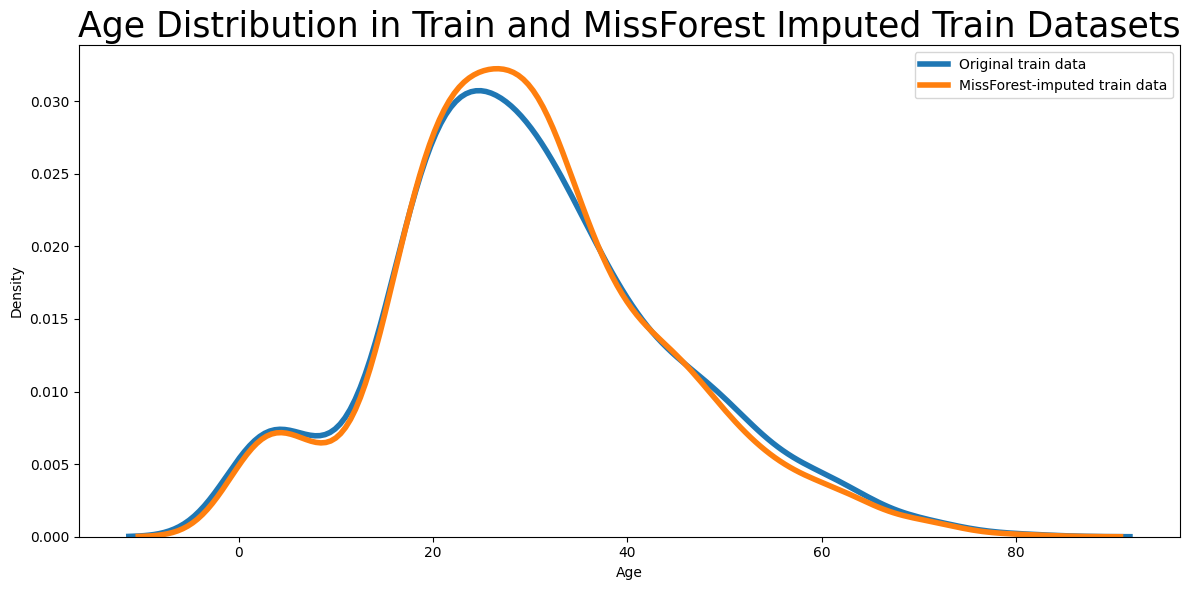

In [360]:
plt.figure(figsize=(12,6))

sns.kdeplot(train.Age, linewidth=4, label='Original train data') 
sns.kdeplot(train_i5.Age, linewidth=4, label='MissForest-imputed train data') 
plt.title('Age Distribution in Train and MissForest Imputed Train Datasets', size=25)
plt.legend()

plt.tight_layout()

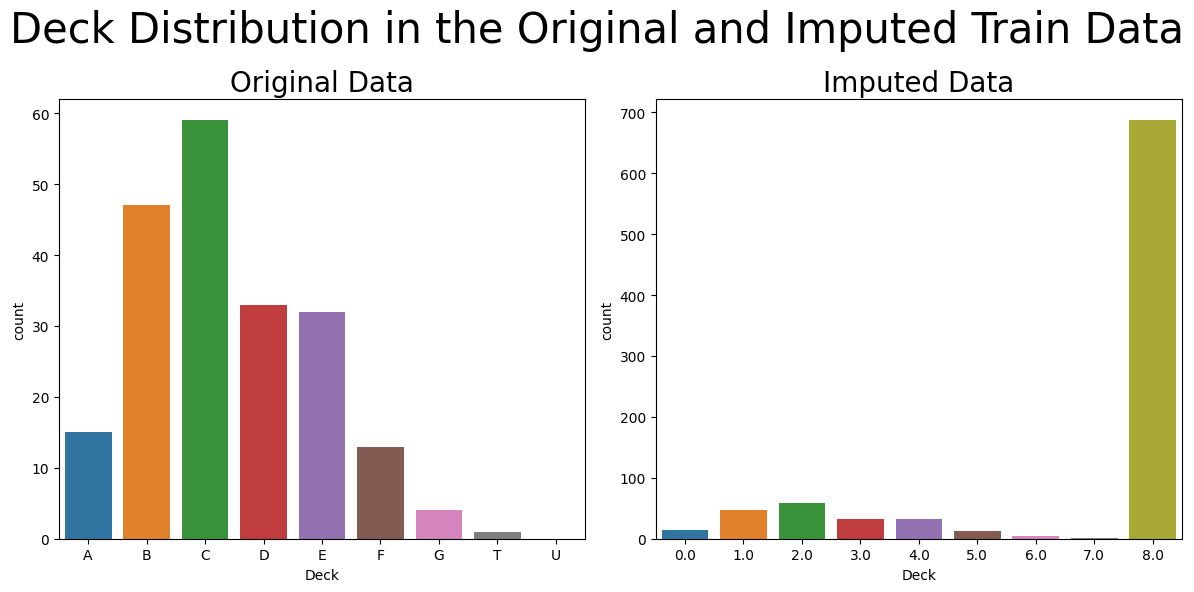

In [361]:
imput_deck_dist = train_i5['Deck'].value_counts().reset_index().sort_values(by='count', ascending=False)


fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.barplot(data=orig_deck_dist, x='Deck', y='count', ax=ax1)
ax1.set_title('Original Data', size=20)

ax2 = sns.barplot(data=imput_deck_dist, x='Deck', y='count', ax=ax2)
ax2.set_title('Imputed Data', size=20)

plt.suptitle('Deck Distribution in the Original and Imputed Train Data', size=30)

plt.tight_layout()

While the imputed Age distribution is similar to the 'original' one, the imputed Deck distribution is very different. It looks like the mode-imputed Deck distribution.

## Imputation with KNN

KNN is basically looking at other features and seeing which of those features are the most similar to the feature you're predicting. If it's a numeric value you use the mean/median of those columns to impute the features; otherwise if its categorical you use the mode. The K in K-nearest neighbours means the number of features you look at (that are close to the feature you're predicting).

KNN imputation is like asking your closest and most knowledgeable classmates for help to fill in your missing answers based on their own knowledge. The idea is that students who are similar to you (in terms of knowledge, just like data points with similar features) will have answers that help you figure out the missing data.

In [362]:
# Use numeric features only
df_train = train.loc[:, num_cols]
df_test  = test.loc[:, num_cols]

imputer = KNNImputer(
    n_neighbors=5, # the number of neighbours K
    weights='distance', # the weighting factor
    metric='nan_euclidean', # the metric to find the neighbours
    add_indicator=False, # whether to add a missing indicator
)

imputer.fit(df_train)

X_train_knn = imputer.transform(df_train)
X_test_knn = imputer.transform(df_test)

# Transform numpy array to dataframe
X_train_knn = pd.DataFrame(X_train_knn, columns=num_cols)
X_test_knn = pd.DataFrame(X_test_knn, columns=num_cols)

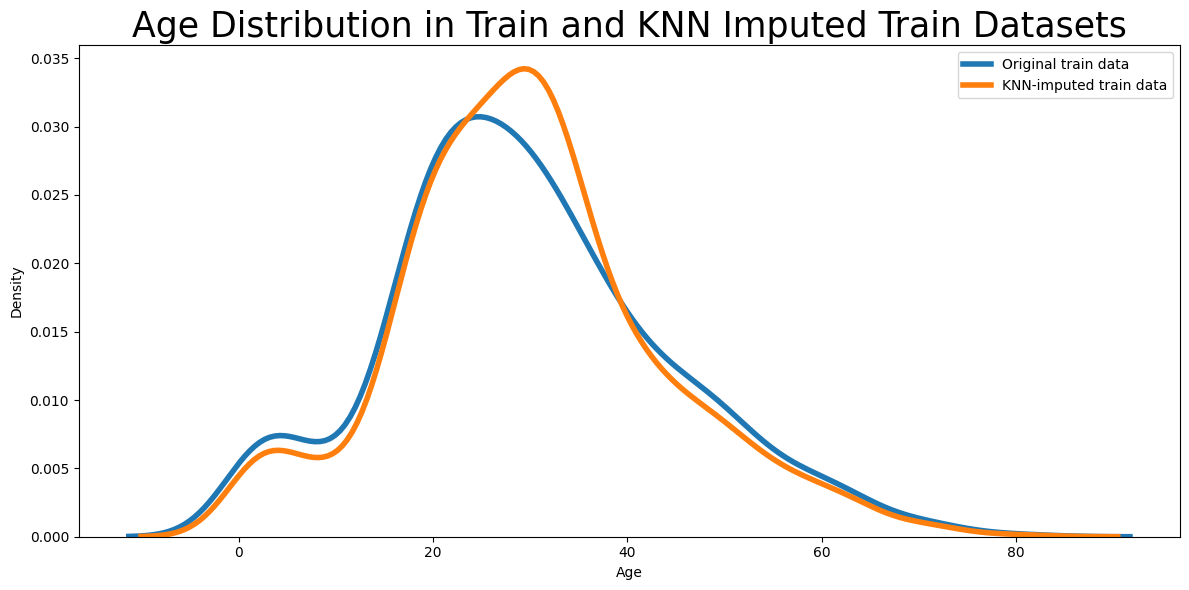

In [363]:
plt.figure(figsize=(12,6))

sns.kdeplot(train.Age, linewidth=4, label='Original train data') 
sns.kdeplot(X_train_knn.Age, linewidth=4, label='KNN-imputed train data') 
plt.title('Age Distribution in Train and KNN Imputed Train Datasets', size=25)
plt.legend()

plt.tight_layout()


# Feature Engineering

## Outliers capping

The outliers can be easily identified by plotting the boxplots of the variables: the points outside of the whiskers range can be identified as such.

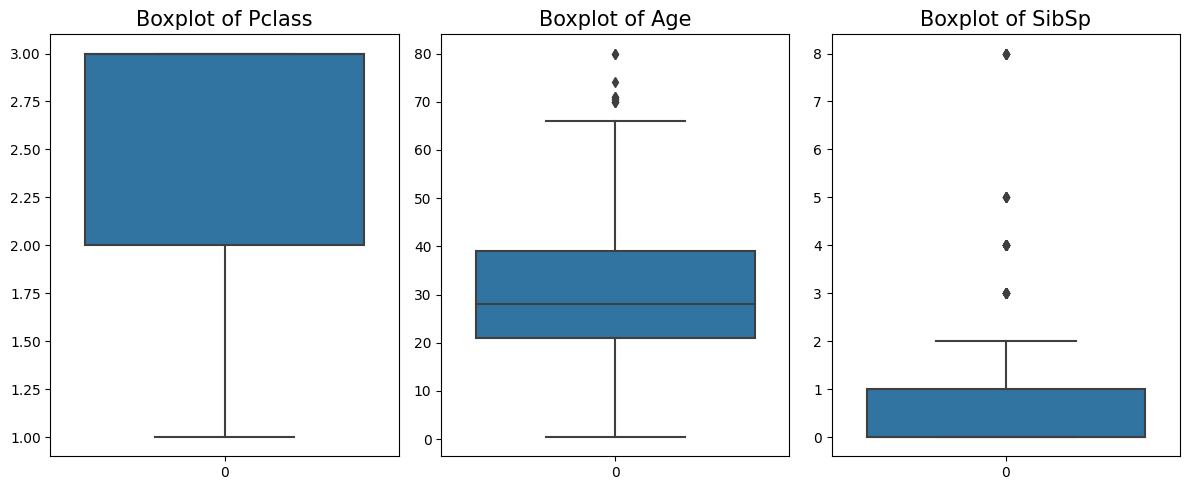

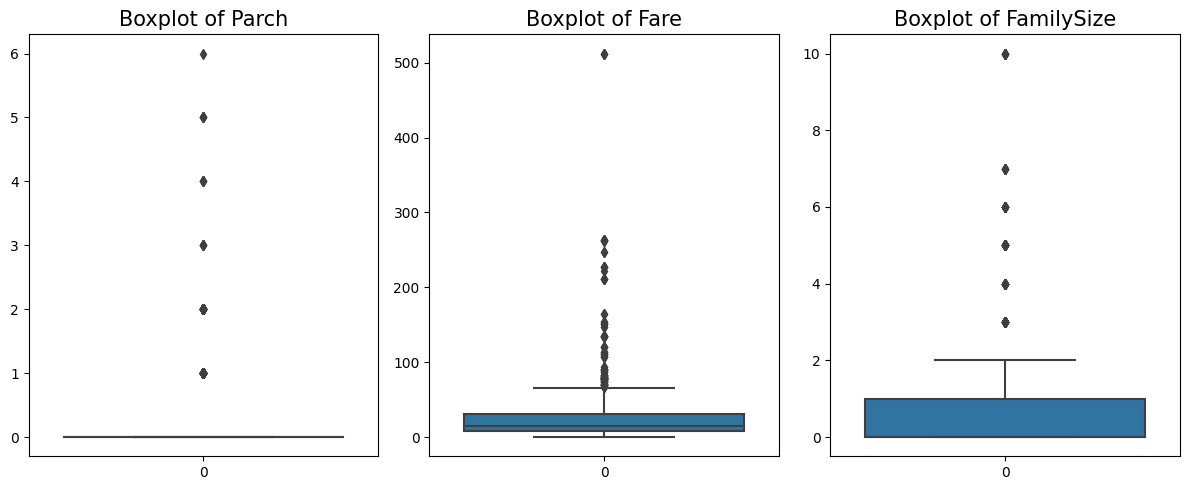

In [364]:
train_to_cap = train_i3.copy()


def plot_boxplots(data, features):

    for i in range(2):
        
        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,5))

        ax1 = sns.boxplot(data[features[i*3]], ax=ax1)
        ax1.set_title(f'Boxplot of {features[i*3]}', size=15)
        ax2 = sns.boxplot(data[features[i*3+1]], ax=ax2)
        ax2.set_title(f'Boxplot of {features[i*3+1]}', size=15)
        ax3 = sns.boxplot(data[features[i*3+2]], ax=ax3)
        ax3.set_title(f'Boxplot of {features[i*3+2]}', size=15)                        

        plt.tight_layout()


plot_boxplots(train_to_cap, num_cols)


I am making a list with the variables that I will need to take care of. The outliers in the other columns do not need capping.



In [365]:
outliers_col = ['Age','Fare']


To make the situation more clear, I am calculating the percentage of the outliers in the data columns.



In [366]:
outliers_perc = []

print('Percentage of outliers in the columns')
print()

def outliers_perc_search(data2, features):
    for k,v in data2[features].items():
        # Column must be of numeric type (not object)
        if data2[k].dtype != 'O':
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(data2)[0]
            out_tuple = (k,int(perc))
            outliers_perc.append(out_tuple)
            print("Column %s outliers = %.1f%%" % (k,perc))


outliers_perc_search(train_to_cap, num_cols)

Percentage of outliers in the columns

Column Pclass outliers = 0.0%
Column Age outliers = 1.2%
Column SibSp outliers = 5.2%
Column Parch outliers = 100.0%
Column Fare outliers = 13.0%
Column FamilySize outliers = 10.2%
Column Mother outliers = 100.0%
Column Single outliers = 0.0%


I am capping the outliers in the Age and Fare columns.



In [367]:
def iqr_winsorize(df, columns, fold=1.5):
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - fold * IQR
        upper = Q3 + fold * IQR
        df[col] = np.clip(df[col], lower, upper)
    return df

train_to_cap = iqr_winsorize(train_to_cap, outliers_col, fold=1.5)


I am plotting the distributions of Age and Fare before and after capping the outliers.



<Figure size 1200x600 with 0 Axes>

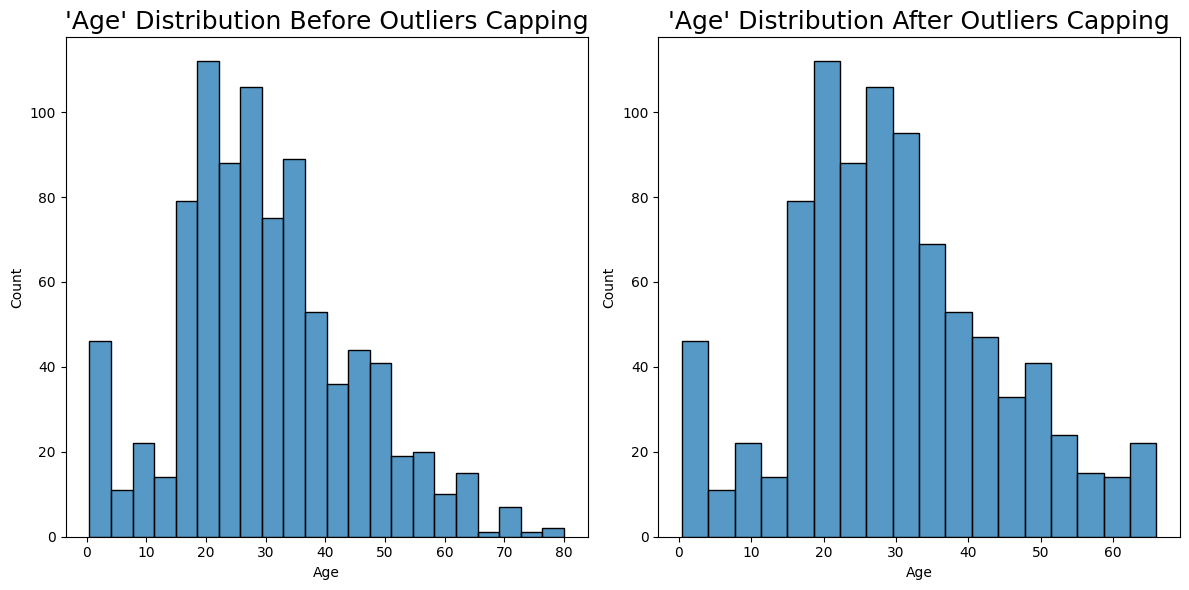

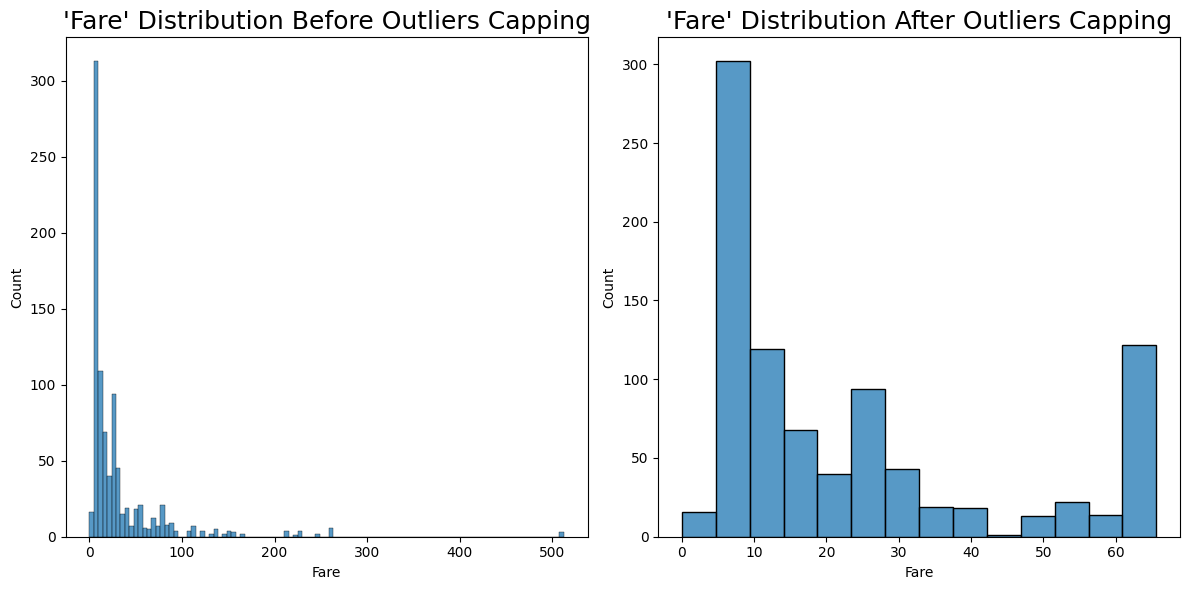

In [368]:
bigfig = plt.figure(figsize=(12,6))

(top,bottom) = bigfig.subfigures(2,1)

### Top figure ###
top.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.histplot(train_i3['Age'], ax=ax1)
ax1.set_title("'Age' Distribution Before Outliers Capping", size=18)

ax2 = sns.histplot(train_to_cap['Age'], ax=ax2)
ax2.set_title("'Age' Distribution After Outliers Capping", size=18)

plt.tight_layout()

### Bottom figure ###
bottom.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.histplot(train_i3['Fare'], ax=ax1)
ax1.set_title("'Fare' Distribution Before Outliers Capping", size=18)

ax2 = sns.histplot(train_to_cap['Fare'], ax=ax2)
ax2.set_title("'Fare' Distribution After Outliers Capping", size=18)

plt.tight_layout()


In [369]:
print(f"Skewness of Age (original): {skew(train_i3['Age'])}")
print(f"Kurtosis of Age (original): {kurtosis(train_i3['Age'])}")

print(f"Skewness of Age (outliers imputed): {skew(train_to_cap['Age'])}")
print(f"Kurtosis of Age (outliers imputed): {kurtosis(train_to_cap['Age'])}")

print()

print(f"Skewness of Fare (original): {skew(train_i3['Fare'])}")
print(f"Kurtosis of Fare (original): {kurtosis(train_i3['Fare'])}")

print(f"Skewness of Fare (outliers imputed): {skew(train_to_cap['Fare'])}")
print(f"Kurtosis of Fare (outliers imputed): {kurtosis(train_to_cap['Fare'])}")

Skewness of Age (original): 0.4203481421591225
Kurtosis of Age (original): 0.19236270122889776
Skewness of Age (outliers imputed): 0.3304747600892131
Kurtosis of Age (outliers imputed): -0.08320090822764481

Skewness of Fare (original): 4.7792532923723545
Kurtosis of Fare (original): 33.20428925264475
Skewness of Fare (outliers imputed): 1.08035588988097
Kurtosis of Fare (outliers imputed): -0.25430901625628355


## Log Transformation

Instead of capping the outliers, I am applying a Log transformation to the Fare column. Then, I will compare the Log-transformed Fare distribution to the 'original' one.

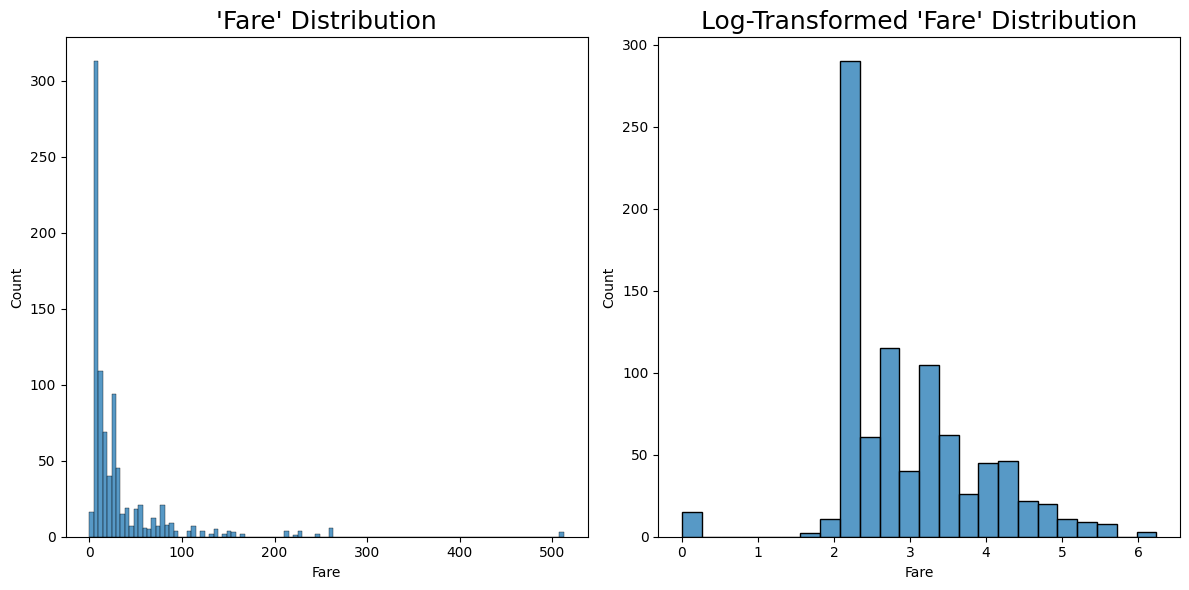

In [370]:
train_log = train_i3.copy()

# Log transformation
train_log['Fare'] = np.log(1 + train_log['Fare'])


fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.histplot(train_i3['Fare'], ax=ax1)
ax1.set_title("'Fare' Distribution", size=18)

ax2 = sns.histplot(train_log['Fare'], ax=ax2)
ax2.set_title("Log-Transformed 'Fare' Distribution", size=18)

plt.tight_layout()

In [371]:
print(f"Skewness of Fare (original): {skew(train_i3['Fare'])}")
print(f"Kurtosis of Fare (original): {kurtosis(train_i3['Fare'])}")

print(f"Skewness of Fare (outliers imputed): {skew(train_log['Fare'])}")
print(f"Kurtosis of Fare (outliers imputed): {kurtosis(train_log['Fare'])}")

Skewness of Fare (original): 4.7792532923723545
Kurtosis of Fare (original): 33.20428925264475
Skewness of Fare (outliers imputed): 0.39426283638993376
Kurtosis of Fare (outliers imputed): 0.9639464598718415


## Box-Cox and Yeo-Johnson Transformations

Box-Cox and Yeo-Johnson are both power **transformations** used to make data more **normally distributed** (reduce skewness)

This helps to:

Reduce skewness (left or right)
Stabilize variance
Make the data more Gaussian (normal)
Improve linear model assumptions


Box Cox Only works on positive values (x > 0), is good for log-normal or right-skewed data and you choose λ (lambda) or let the algorithm find the best one.

Yeo- Johnson works on both positive and negative values, is a generalization of Box-Cox, is useful if your data includes 0s or negative numbers

**Use these when:**

Your model assumes normality (like linear regression)
Your features are skewed and might distort learning
You're preparing data for PCA or clustering

Lambda value used for Transformation: 0.7734731239170468


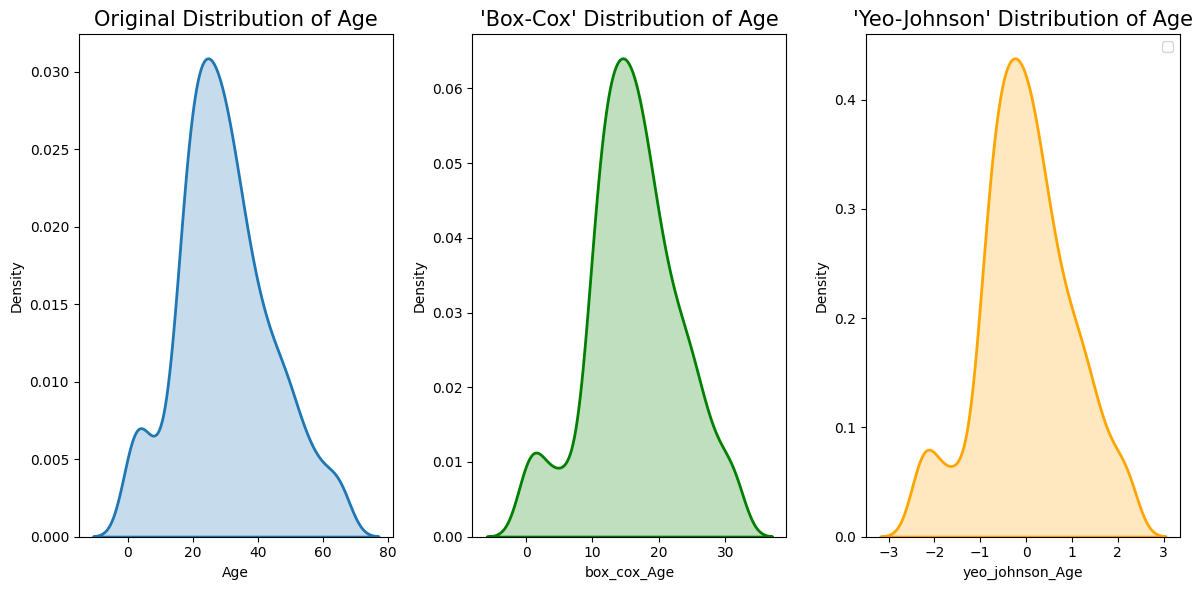

In [372]:
### Box-Cox transformation & lambda value ###
train_to_cap['box_cox_Age'], fitted_lambda = stats.boxcox(train_to_cap['Age'])


### Yeo-Johnson transformation ###
power = PowerTransformer(method='yeo-johnson',standardize=True)

YJ_cols = ['yeo_johnson_Age','XXX']
train_to_cap['yeo_johnson_Age'] = train_to_cap['Age']
train_to_cap['XXX'] = train_to_cap['Age']

train_to_cap[YJ_cols] = power.fit_transform(train_to_cap[YJ_cols])

train_to_cap.drop('XXX',axis=1,inplace=True)


### Plot the distributions ###
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))
 
# plotting the original data(non-normal) and 
# fitted data (normal)
ax1 = sns.distplot(train_to_cap['Age'],hist=False,kde=True,
            kde_kws={'shade': True,'linewidth': 2}, 
            label="Non-Normal",ax=ax1)
ax1.set_title('Original Distribution of Age',size=15)
 
ax2 = sns.distplot(train_to_cap['box_cox_Age'],hist=False,kde=True,
            kde_kws={'shade':True,'linewidth':2}, 
            color="green",ax=ax2)
ax2.set_title("'Box-Cox' Distribution of Age",size=15)

ax3 = sns.distplot(train_to_cap['yeo_johnson_Age'],hist=False,kde=True,
            kde_kws={'shade':True,'linewidth':2}, 
            color="orange",ax=ax3)
ax3.set_title("'Yeo-Johnson' Distribution of Age",size=15)
 
# adding legends to the subplots 
plt.legend(loc="upper right")

plt.tight_layout()
 
print(f"Lambda value used for Transformation: {fitted_lambda}")

In [373]:
print(f"Skewness of Age (outliers imputed): {skew(train_to_cap['Age'])}")
print(f"Kurtosis of Age (outliers imputed): {kurtosis(train_to_cap['Age'])}")

print()

print(f"Skewness of Age (Box-Cox): {skew(train_to_cap['box_cox_Age'])}")
print(f"Kurtosis of Age (Box-Cox): {kurtosis(train_to_cap['box_cox_Age'])}")

print()

print(f"Skewness of Age (Yeo-Johnson): {skew(train_to_cap['yeo_johnson_Age'])}")
print(f"Kurtosis of Age (Yeo-Johnson): {kurtosis(train_to_cap['yeo_johnson_Age'])}")

Skewness of Age (outliers imputed): 0.3304747600892131
Kurtosis of Age (outliers imputed): -0.08320090822764481

Skewness of Age (Box-Cox): -0.05905066648358804
Kurtosis of Age (Box-Cox): 0.028767977064502404

Skewness of Age (Yeo-Johnson): -0.03757409026281666
Kurtosis of Age (Yeo-Johnson): 0.0009203606301535494


## Rare Labels in Categorical Columns

I am plotting the histograms of the categorical variables (those after random imputation). I am also plotting a five percent threshold line. The classes with a count smaller than this threshold are to be considered as rare and have to be encoded accordingly.

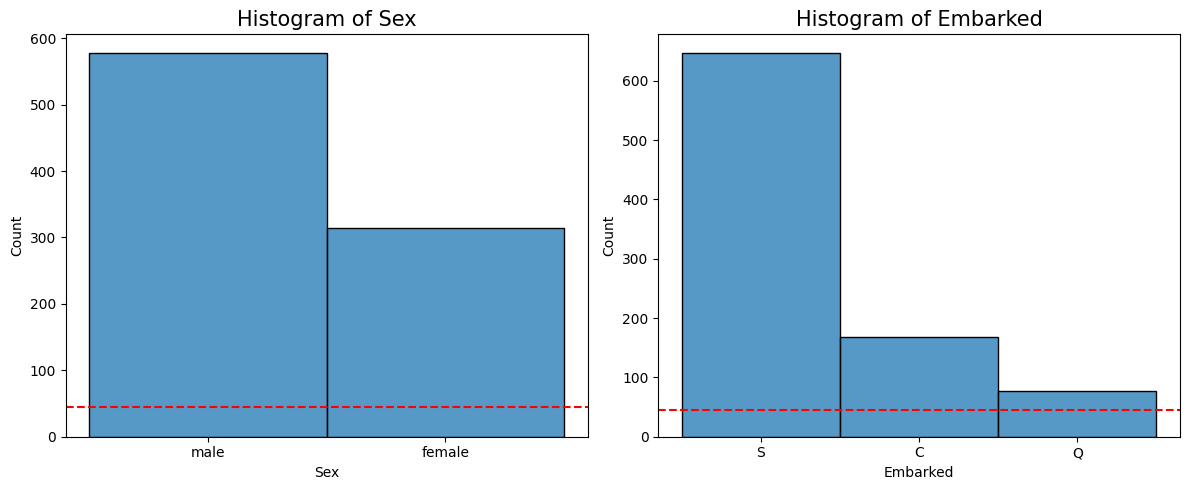

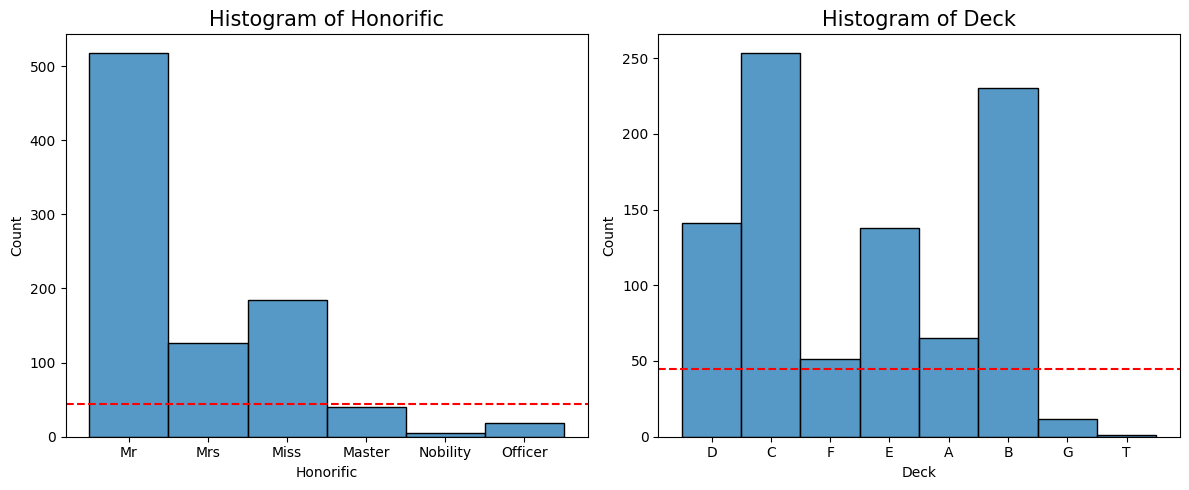

In [374]:
five_perc_threshold = len(train_i3) * 0.05


for i in range(2):
        
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))

    ax1 = sns.histplot(train_i3[cat_cols[i*2]], ax=ax1)
    ax1.set_title(f'Histogram of {cat_cols[i*2]}', size=15)
    ax1.axhline(five_perc_threshold, ls='--', color='red')

    ax2 = sns.histplot(train_i3[cat_cols[i*2+1]], ax=ax2)
    ax2.set_title(f'Histogram of {cat_cols[i*2+1]}', size=15) 
    ax2.axhline(five_perc_threshold, ls='--', color='red')

    plt.tight_layout()

The Honorific and Deck columns have classes with a frequency < 0.05. They will have to be encoded as rare labels in the final classification pipeline.

## Feature Importance and Correlations

Before moving to the classification part, I want to have a look at the feature importance plot and the correlation heatmap to see if there might be unnecessary variables or variables that need to be dropped.

In [375]:
X_train_fi, X_valid_fi, y_train_fi, y_valid_fi = train_test_split(
    train_i3, target, test_size=0.3, random_state=42
)

# Step 1: Rare label encoding (combine rare categories)
def rare_label_encoding(df, columns, tol=0.05):
    df = df.copy()
    for col in columns:
        freq = df[col].value_counts(normalize=True)
        rare_labels = freq[freq < tol].index
        df[col] = df[col].apply(lambda x: 'Rare' if x in rare_labels else x)
    return df

# Apply rare label encoding
X_train_fi = rare_label_encoding(X_train_fi, cat_cols, tol=0.05)

# Step 2: One-hot encoding
X_train_fi = pd.get_dummies(X_train_fi, columns=cat_cols, drop_first=True)

In [376]:
# Random Forest Model
random_forest = RandomForestClassifier(random_state=1, max_depth=200)
random_forest.fit(X_train_fi, y_train_fi)
 
importances = pd.DataFrame({'feature':X_train_fi.columns, 'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance', ascending=False)
importances.head()

,feature,importance
1,Age,0.194
4,Fare,0.191
8,Sex_male,0.127
11,Honorific_Mr,0.118
0,Pclass,0.075


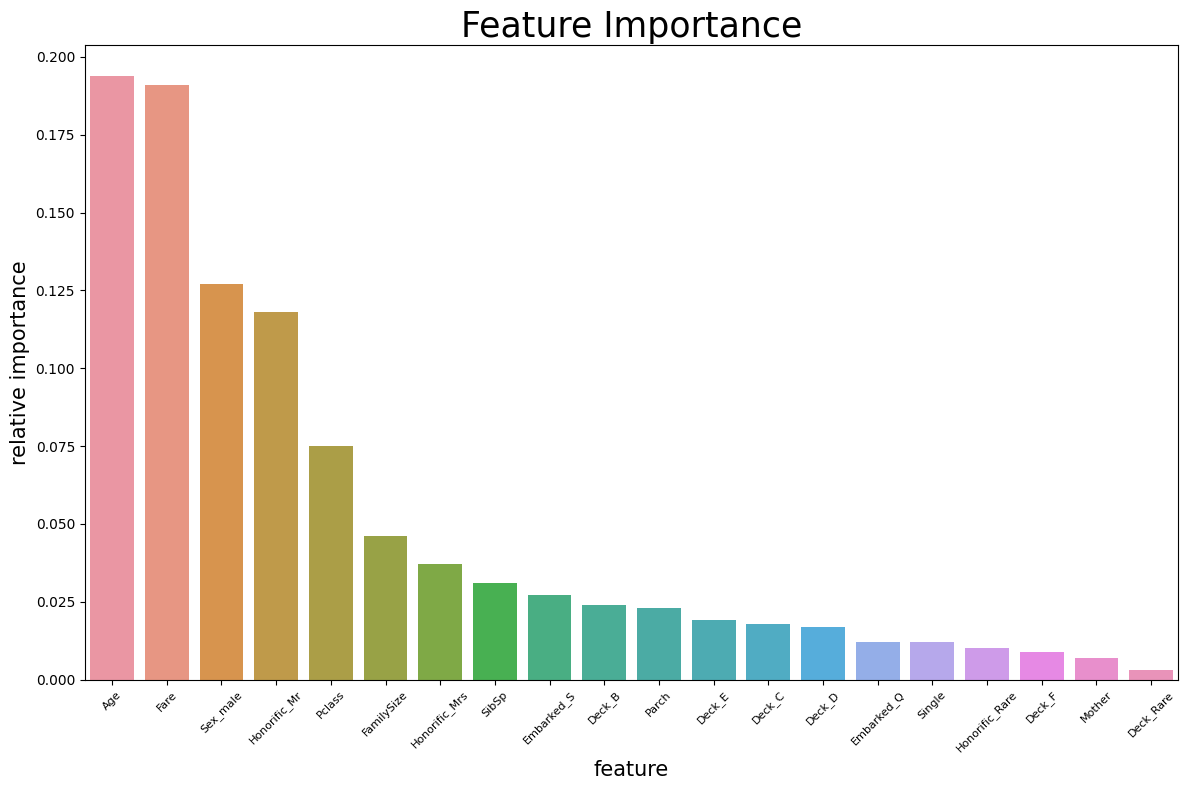

In [377]:
plt.figure(figsize=(12,8))

sns.barplot(importances, x='feature', y='importance')

plt.title('Feature Importance', fontsize=25)
plt.xlabel('feature', fontsize=15)
plt.xticks(fontsize=8, rotation=45)
plt.ylabel('relative importance', fontsize=15)
    
plt.tight_layout()
plt.show()

These are supposed to be the most important predictors. Let's see if a plot of the permutation based importance gives the same results.

In [378]:
perm_importance = permutation_importance(random_forest, X_train_fi, y_train_fi)

sorted_idx = (-perm_importance.importances_mean).argsort()

list_of_tuples  = list(zip(X_train_fi.columns[sorted_idx],
                           perm_importance.importances_mean[sorted_idx]))

perm_importance = pd.DataFrame(list_of_tuples,
                  columns=['feature','permutation importance'])

perm_importance.head()

,feature,permutation importance
0,Fare,0.103050
1,Pclass,0.099197
2,Age,0.082825
3,Sex_male,0.081541
4,Honorific_Mr,0.047833


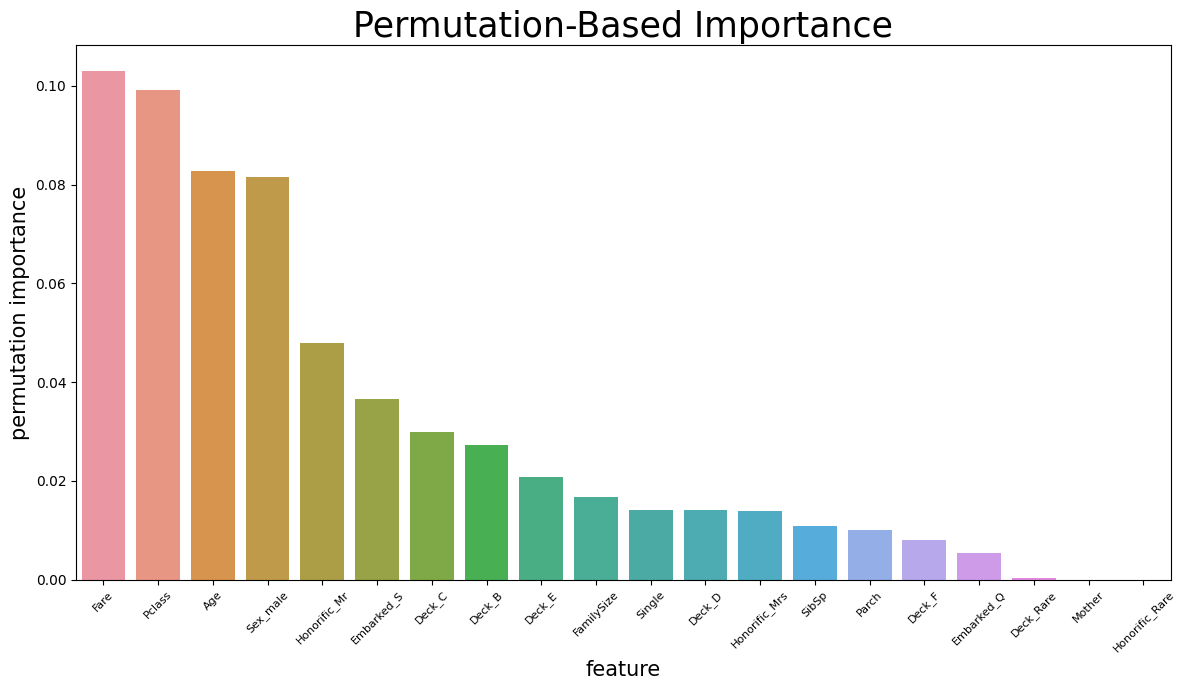

In [379]:
plt.figure(figsize=(12,7))

sns.barplot(perm_importance, x='feature', y='permutation importance')

plt.title('Permutation-Based Importance', fontsize=25)
plt.xlabel('feature', fontsize=15)
plt.xticks(fontsize=8, rotation=45)
plt.ylabel('permutation importance', fontsize=15)
    
plt.tight_layout()

The results of this second plot are different from that of the feature importance, even though the same variables (Pclass, Fare, Age, Honorific_Mr) occupy the first positions in the chart. These plots can also help to see what the least important variables might be.

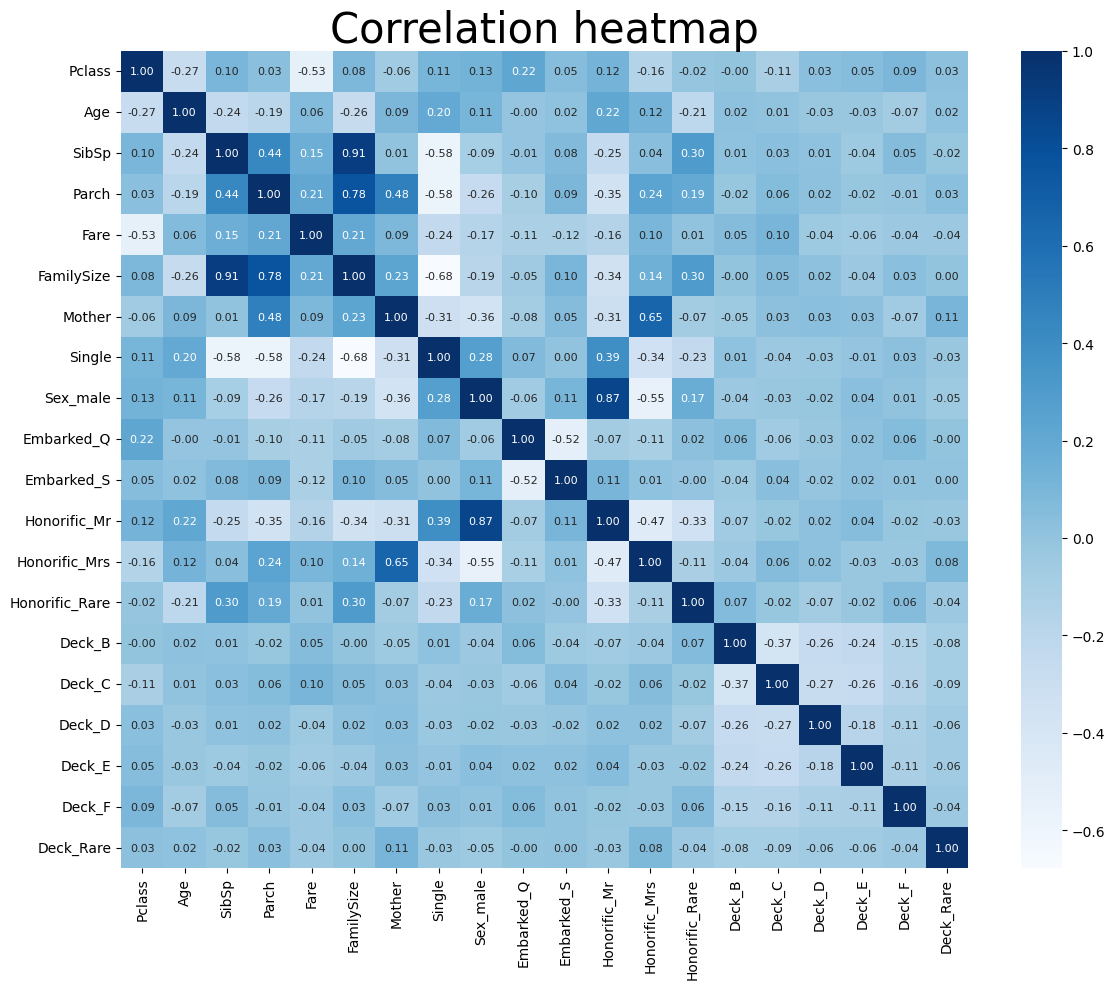

In [380]:
plt.figure(figsize=(12,10))

sns.heatmap(X_train_fi.corr(method='pearson'), annot=True, fmt='.2f', annot_kws={"fontsize":8}, cmap='Blues')
plt.title('Correlation heatmap', fontsize=30)

plt.tight_layout()
plt.show()

The correlation heatmap shows that there is a really strong correlation between SibSp and FamilySize. Dropping one of the variables might reduce the risk of overfitting. It will be worth to see what happens on the test data if I keep SibSp or if I drop it (the feature importance of SibSp is lower than that of FamilySize, this is why I would drop it instead of the other one).


RandomForest feature importance measures how much each feature reduces impurity (like Gini) across all trees during training. It's fast but can be biased toward features with more levels or continuous values. In contrast, permutation importance evaluates how much a model's performance drops when a feature's values are randomly shuffled. This makes it more accurate and model-agnostic, but also slower. Overall, permutation importance better reflects a feature’s true impact on predictions.

# **Classification Pipelines**

## Random forest Classification Pipeline

In [381]:
num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Categorical transformer
cat_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Full preprocessor
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Final pipeline with classifier
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf_classifier', RandomForestClassifier(random_state=42))
])

In [382]:
num_cols

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Mother', 'Single']

First, I am using the pipeline on the dataset with the null values imputed by median and mode.



In [383]:
# Dropping 'SibSp'
train_i1.drop('SibSp', axis=1, inplace=True)
test_i1.drop('SibSp', axis=1, inplace=True)
num_cols.remove('SibSp')

# Train-validation split
X_train_i1, X_valid_i1, y_train_i1, y_valid_i1 = train_test_split(train_i1, target, test_size=0.3, random_state=42)

pipe_rf.fit(X_train_i1, y_train_i1)

print(f'Train accuracy: {pipe_rf.score(X_train_i1, y_train_i1):.3f}')
print(f'Test accuracy: {pipe_rf.score(X_valid_i1, y_valid_i1):.3f}')

Train accuracy: 0.984
Test accuracy: 0.799


Then, I am using the pipeline on the dataset with the null values random imputed.



In [384]:
# Dropping 'SibSp'
train_i3.drop('SibSp', axis=1, inplace=True)
test_i3.drop('SibSp', axis=1, inplace=True)

# Train-validation split
X_train_i3, X_valid_i3, y_train_i3, y_valid_i3 = train_test_split(train_i3, target, test_size=0.3, random_state=42)

pipe_rf.fit(X_train_i3, y_train_i3)

print(f'Train accuracy: {pipe_rf.score(X_train_i3, y_train_i3):.3f}')
print(f'Test accuracy: {pipe_rf.score(X_valid_i3, y_valid_i3):.3f}')

Train accuracy: 0.995
Test accuracy: 0.802


In [385]:
y_pred_pipe_rf = pipe_rf.predict(X_valid_i3)

print(classification_report(y_valid_i3, y_pred_pipe_rf))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       157
           1       0.78      0.72      0.75       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



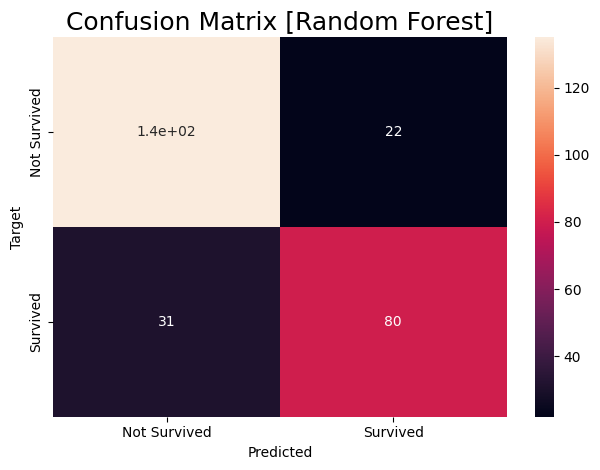

In [386]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_valid_i3, y_pred_pipe_rf)

ax = sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix [Random Forest]', fontsize=18)
ax.xaxis.set_ticklabels(['Not Survived','Survived']) 
ax.yaxis.set_ticklabels(['Not Survived','Survived']) 
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.tight_layout()

A pipeline in machine learning is a streamlined way to chain together multiple data processing and modeling steps into one object. It ensures that all steps are applied in the correct order, and helps avoid data leakage, especially during cross-validation.

Think of a pipeline like an assembly line in a factory:
Step 1: Clean the data
Step 2: Transform or reduce it
Step 3: Train a model
Each step feeds into the next — and the same process can be applied later to new data (like test data).

TP  FP
FN  TN

TP: Test says someone has the disease → they actually do.
TN: Test says someone is healthy → they actually are.
FP: Test says someone has the disease → but they don’t.
FN: Test says someone is healthy → but they actually have the disease.

**Precision**
How many of the predicted positives are actually correct?
Formula: Precision= True Positives/ (True Positives + False Positives)

**Recall**
How many of the actual positives did your model correctly find?
Formula: Recall= True Positives/ (True Positives + False Negatives)

**F1-Score**
Harmonic mean of precision and recall
F1= 2⋅(Precision⋅Recall) / (Precision + Recall)

A classification report is all this for each class and support (number of actual instances per class) and an average score at the bottom (macro, weighted, etc.)




## GradientBoosting Classification Pipeline


In [387]:
pipe_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('gradient_boosting', GradientBoostingClassifier(random_state=42))
])

In [388]:
# Pipeline on the dataset with the null values imputed by median and mode
pipe_gb.fit(X_train_i1, y_train_i1)

print(f'Train accuracy: {pipe_gb.score(X_train_i1, y_train_i1):.3f}')
print(f'Test accuracy: {pipe_gb.score(X_valid_i1, y_valid_i1):.3f}')

Train accuracy: 0.918
Test accuracy: 0.810


In [389]:
# Pipeline on the dataset with the null values random imputed
pipe_gb.fit(X_train_i3, y_train_i3)

print(f'Train accuracy: {pipe_gb.score(X_train_i3, y_train_i3):.3f}')
print(f'Test accuracy: {pipe_gb.score(X_valid_i3, y_valid_i3):.3f}')

Train accuracy: 0.915
Test accuracy: 0.802


In [390]:
from sklearn.metrics import classification_report

# Predict using the gradient boosting pipeline
y_pred_pipe_gb = pipe_gb.predict(X_valid_i3)

# Print the classification report
print(classification_report(y_valid_i3, y_pred_pipe_gb))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       157
           1       0.81      0.68      0.74       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



##  Logistic Regression Pipeline

In [391]:
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logistic_regression', LogisticRegression(random_state=42))
])

In [392]:
# Pipeline on the dataset with the null values imputed by median and mode
pipe_logreg.fit(X_train_i1, y_train_i1)

print(f'Train accuracy: {pipe_logreg.score(X_train_i1, y_train_i1):.3f}')
print(f'Test accuracy: {pipe_logreg.score(X_valid_i1, y_valid_i1):.3f}')

Train accuracy: 0.838
Test accuracy: 0.821


In [393]:
# Pipeline on the dataset with the null values random imputed
pipe_logreg.fit(X_train_i3, y_train_i3)

print(f'Train accuracy: {pipe_logreg.score(X_train_i3, y_train_i3):.3f}')
print(f'Test accuracy: {pipe_logreg.score(X_valid_i3, y_valid_i3):.3f}')

Train accuracy: 0.839
Test accuracy: 0.821


In [394]:
y_pred_pipe_logreg = pipe_logreg.predict(X_valid_i3)

print(classification_report(y_valid_i3, y_pred_pipe_logreg))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       157
           1       0.81      0.75      0.78       111

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



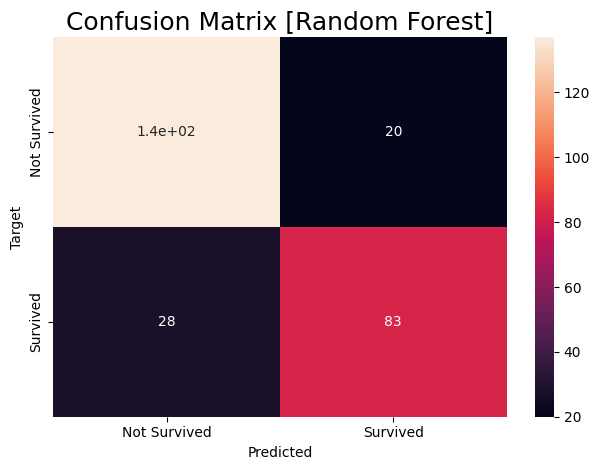

In [395]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_valid_i3, y_pred_pipe_logreg)

ax = sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix [Random Forest]', fontsize=18)
ax.xaxis.set_ticklabels(['Not Survived','Survived']) 
ax.yaxis.set_ticklabels(['Not Survived','Survived']) 
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.tight_layout()

## Random Forest Classification Pipeline with GridSearch

The first step is to explore the possible range of the model parameters' values by means of validation curves.



In [396]:
def plot_validation_curve(clf,X,y,CV,param_name,param_range,y_lim=[0.8, 0.95]):

    train_scores, test_scores = validation_curve(
                estimator = clf, 
                X = X, 
                y = y, 
                param_name = param_name, 
                param_range = param_range,
                cv = CV)

    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    test_std = np.std(test_scores,axis=1)

    plt.figure(figsize=(12,6))

    plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
    
    plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

    plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

    plt.xlim([param_range[0], param_range[-1]])
    plt.ylim(y_lim)

    plt.grid()
    plt.legend(loc='lower right')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Accuracy')
    plt.title(f"Validation Curve of '{param_name}'", size=25)

    plt.tight_layout()
    plt.show()

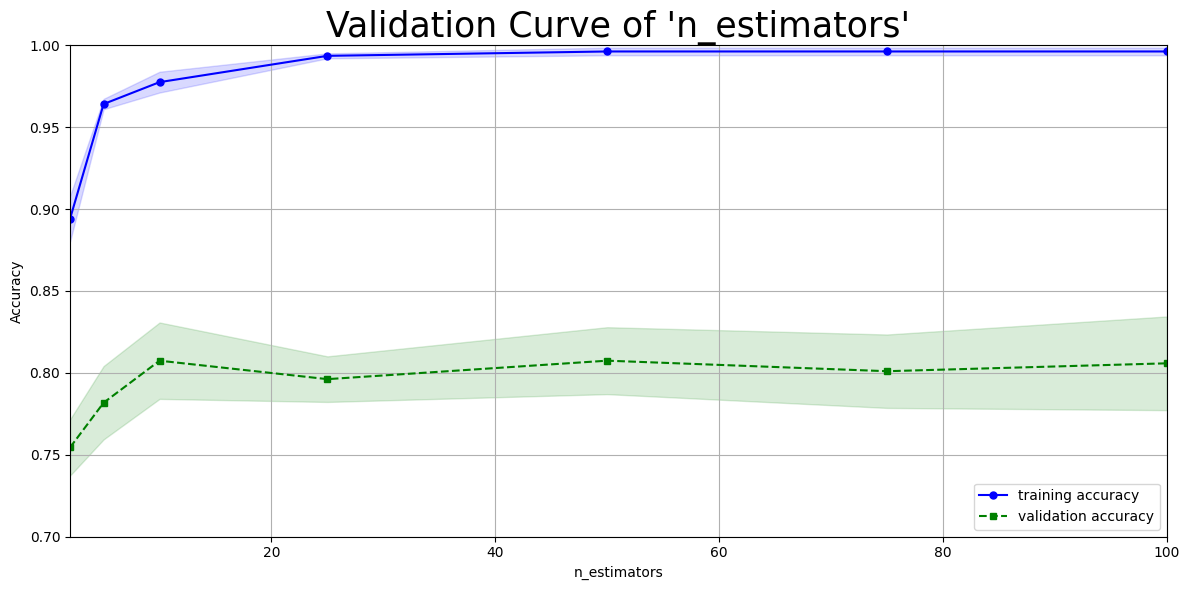

In [397]:
rf_class = RandomForestClassifier(random_state=42)

# Preprocess X_train
X_train_i3_prec = X_train_i3.copy()
X_train_i3_prec = preprocessor.fit_transform(X_train_i3_prec)

plot_validation_curve(rf_class, X_train_i3_prec, y_train_i3, 4, 'n_estimators', [2,5,10,25,50,75,100], y_lim=[0.7,1.0])

The 'best' value of n_estimators is > 30 and < 60.



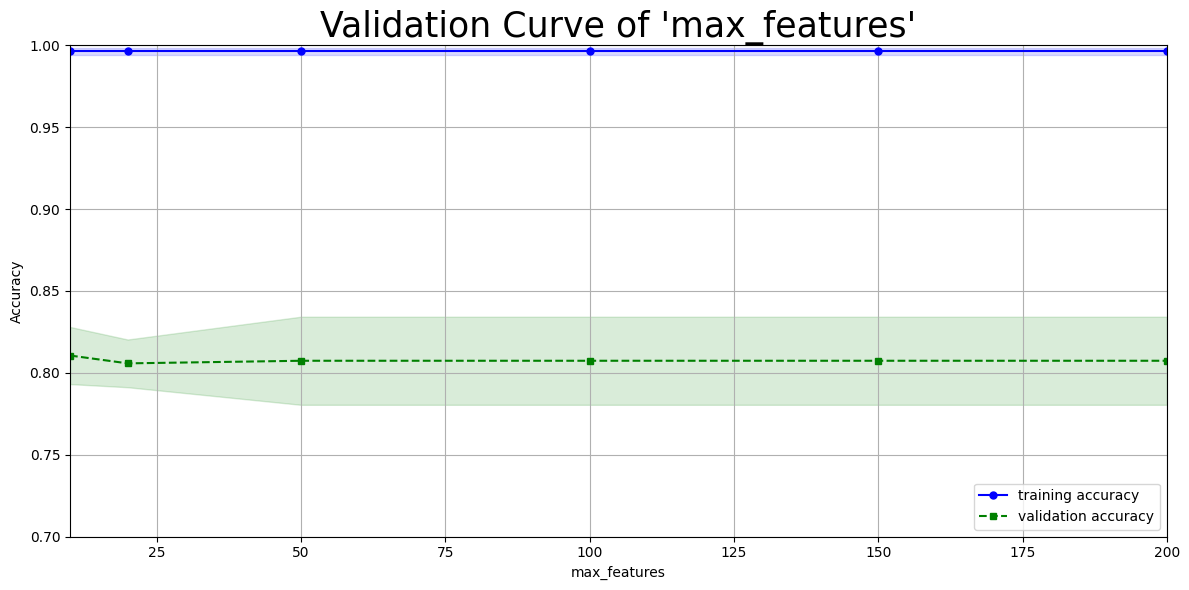

In [398]:
plot_validation_curve(rf_class, X_train_i3_prec, y_train_i3, 4, 'max_features', [10,20,50,100,150,200], y_lim=[0.7,1.0])

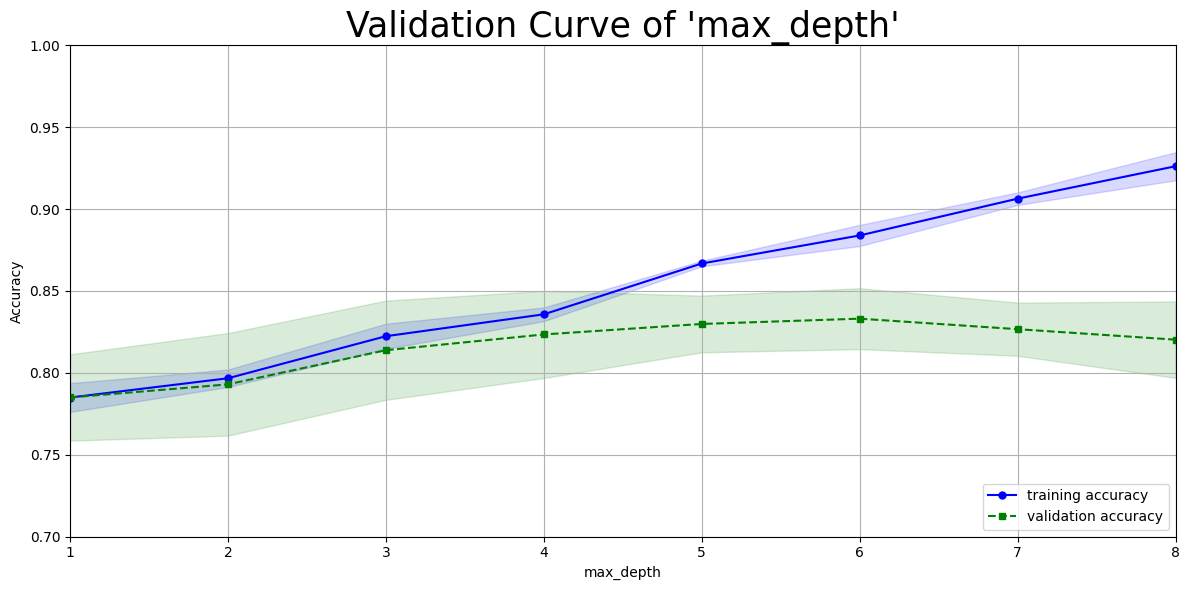

In [399]:
plot_validation_curve(rf_class, X_train_i3_prec, y_train_i3, 4, 'max_depth', [1,2,3,4,5,6,7,8], y_lim=[0.7,1.])

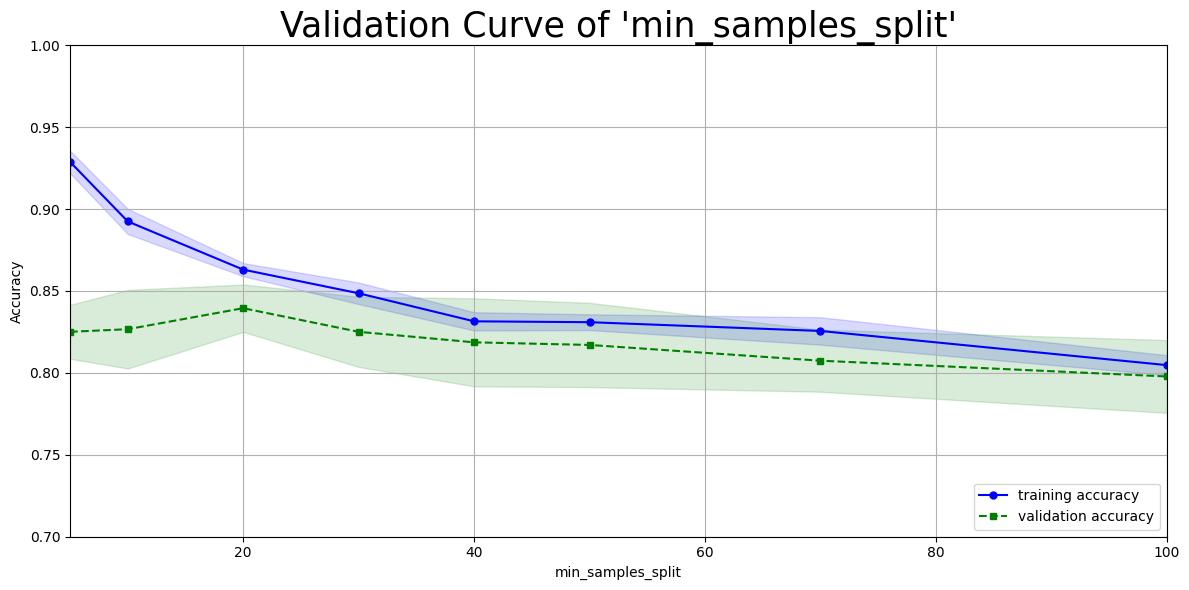

In [400]:
plot_validation_curve(rf_class, X_train_i3_prec, y_train_i3, 4, 'min_samples_split', [5,10,20,30,40,50,70,100], y_lim=[0.7,1.])

The 'best' value of min_samples_split is between 10 and 30.



In [401]:
cv_params = {'n_estimators': [30],
             'max_depth': [5],
             'min_samples_split': [10,20,30]}

rf_grid = GridSearchCV(estimator=rf_class, param_grid=cv_params, cv=10)

pipe_rf_grid = Pipeline([
    ('preprocessor', preprocessor),
    ('rf_grid_search', rf_grid)
])

pipe_rf_grid.fit(X_train_i3, y_train_i3)

print(f'Train accuracy: {pipe_rf_grid.score(X_train_i3, y_train_i3):.3f}')
print(f'Test accuracy: {pipe_rf_grid.score(X_valid_i3, y_valid_i3):.3f}')

print(rf_grid.best_params_)

Train accuracy: 0.851
Test accuracy: 0.825
{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 30}


In [402]:
y_pred_pipe_rf_grid = pipe_rf_grid.predict(X_valid_i3)

print(classification_report(y_valid_i3, y_pred_pipe_rf_grid))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       157
           1       0.85      0.70      0.77       111

    accuracy                           0.82       268
   macro avg       0.83      0.81      0.81       268
weighted avg       0.83      0.82      0.82       268



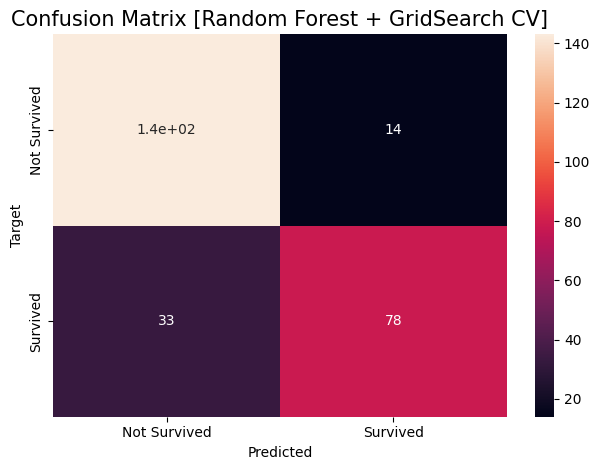

In [403]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_valid_i3, y_pred_pipe_rf_grid)

ax = sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix [Random Forest + GridSearch CV]', fontsize=15)
ax.xaxis.set_ticklabels(['Not Survived','Survived']) 
ax.yaxis.set_ticklabels(['Not Survived','Survived']) 
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

plt.tight_layout()


## Logistic Regression Classification Pipeline with GridSearch

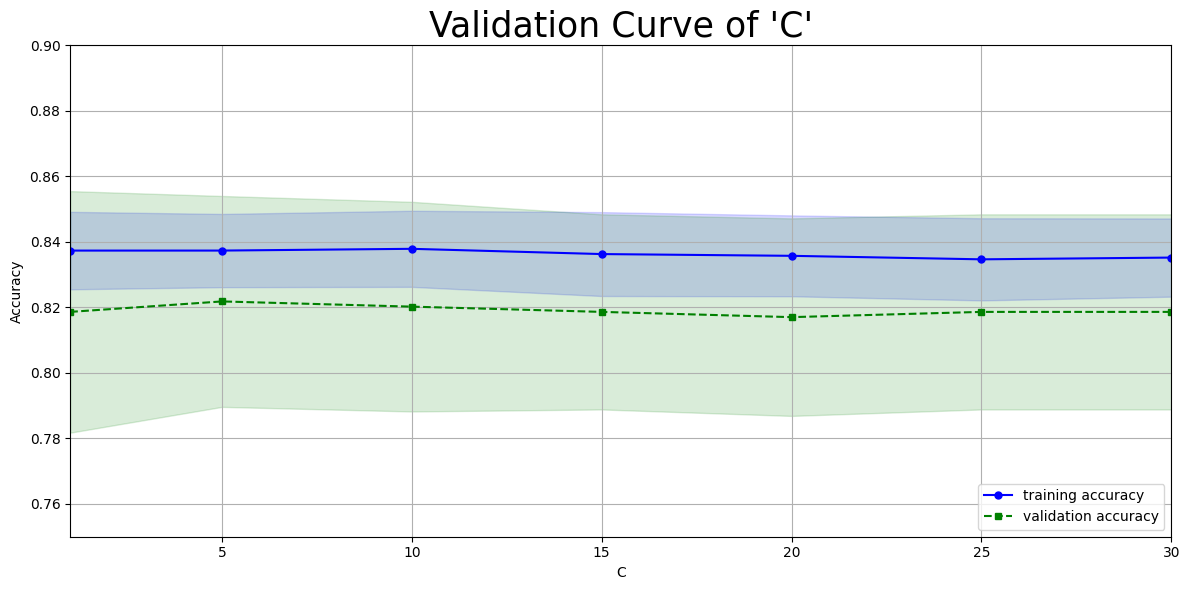

In [404]:
logreg_class = LogisticRegression(random_state=42, max_iter=1000)  # increased max_iter to ensure convergence

# Preprocess training data (if not already done)
X_train_i3_prec = X_train_i3.copy()
X_train_i3_prec = preprocessor.fit_transform(X_train_i3_prec)

# Plot validation curve for Logistic Regression on the hyperparameter 'C'
plot_validation_curve(
    logreg_class, 
    X_train_i3_prec, 
    y_train_i3, 
    4,                    # Number of folds for CV
    'C',
    [1, 5, 10, 15, 20, 25, 30],  # Range of C values to test
    y_lim=[0.75, 0.9]      # Limits for y-axis (accuracy range)
)

the 'best' C value is 5

In [405]:
logreg_class = LogisticRegression(random_state=42, max_iter=1000)

pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', logreg_class)
])

# Define param grid with pipeline step prefix "logreg__"
cv_params_logreg = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l2'],
}

# Create GridSearchCV with the pipeline as the estimator
logreg_grid = GridSearchCV(pipe_logreg, param_grid=cv_params_logreg, cv=10)

# Fit the grid search
logreg_grid.fit(X_train_i3, y_train_i3)

print(f'Train accuracy: {logreg_grid.score(X_train_i3, y_train_i3):.3f}')
print(f'Test accuracy: {logreg_grid.score(X_valid_i3, y_valid_i3):.3f}')
print(logreg_grid.best_params_)


Train accuracy: 0.833
Test accuracy: 0.810
{'logreg__C': 10, 'logreg__penalty': 'l2'}


In [406]:
y_pred_logreg_grid = logreg_grid.predict(X_valid_i3)

print(classification_report(y_valid_i3, y_pred_logreg_grid))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       157
           1       0.79      0.74      0.76       111

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268



## GradientBoosting Classification Pipeline with GridSearch

In [407]:
# Define the Gradient Boosting classifier
gb_class = GradientBoostingClassifier(random_state=42)

# Define the hyperparameter grid to search
cv_params = {
    'gradient_boosting__n_estimators': [30],
    'gradient_boosting__max_depth': [5],
    'gradient_boosting__min_samples_split': [10, 20, 30]
}

# Create GridSearchCV with the classifier and param grid
gb_grid = GridSearchCV(estimator=gb_class, param_grid=cv_params, cv=10)

# Create the pipeline including preprocessing and grid search
pipe_gb_grid = Pipeline([
    ('preprocessor', preprocessor),
    ('gradient_boosting', gb_class)
])

# Now fit GridSearchCV on the preprocessed training data (use pipeline with GridSearchCV)
pipe_gb_grid = GridSearchCV(pipe_gb_grid, param_grid=cv_params, cv=10)
pipe_gb_grid.fit(X_train_i3, y_train_i3)

# Print train and test accuracy
print(f'Train accuracy: {pipe_gb_grid.score(X_train_i3, y_train_i3):.3f}')
print(f'Test accuracy: {pipe_gb_grid.score(X_valid_i3, y_valid_i3):.3f}')

# Print best hyperparameters found
print(pipe_gb_grid.best_params_)


Train accuracy: 0.909
Test accuracy: 0.795
{'gradient_boosting__max_depth': 5, 'gradient_boosting__min_samples_split': 30, 'gradient_boosting__n_estimators': 30}


# Submit Predictions


In [408]:
pred = pipe_rf_grid.predict(test_i3)

submit = pd.DataFrame({'PassengerId':test_id,'Survived':pred})

submit.to_csv('submission_titanic.csv',index=False)